In [3]:
%%capture
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from tensorflow.keras import layers, utils, losses, models as mds, optimizers
from matplotlib import pyplot as plt

if imp.find_loader('aggdraw'): import aggdraw
if imp.find_loader('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers

2022-03-17 13:22:54.973422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-17 13:22:54.973561: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Summary

| Version | Depth | Skips | Others | Accuracy | Validation Accuracy |
| :-- | :-: | :-- | :-- | :-: | :-: |
| 3 | 20 | [2, 3, 5, 8] || 0.134314  |  0.103922 |
| 5 | 30 | [2, 3, 5, 8, 13, 21] | heat=1, chill=3, skip_start_depth=10 | 0.240196 | 0.137255 |
| 6 | 60 | [2, 3, 5, 8, 13, 21] | heat=1, chill=2, reheat=7, skip_start_depth=10 | 0.036275 | 0.037255 |
| 7 | 30 | [2, 3, 5, 8, 13, 21] || 0.134314 | 0.094118 |
| 8 | 30 | [2, 3, 5, 8, 13, 21] || 0.041176 | 0.035294 |
| 10 | 20 | [2, 3, 5, 8, 13] || 0.182353 | 0.083333 |
| 11 | 30 | [2, 3, 5, 8, 13, 21] | Conv Merge | 0.079412 | 0.055882 |
| 12 | 30 | [2, 3, 5, 8, 13, 21] | Dense Merge | 0.185294 | 0.089216 |
| 13 | 30 | [2, 3, 5, 8, 13] || 0.131373 | 0.098039 |
| 21 | 5 ||| 0.976471 | 0.32549 |

* Versions correspond to the kaggle [runs](https://www.kaggle.com/naresh/auto-model)

## Common Functions

In [4]:
def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', edgecolor='k')

    axes[0].plot(h['loss'], label='Loss')
    axes[0].plot(h['val_loss'], label='Validation Loss')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Losses')

    axes[1].plot(h['accuracy'], label='Accuracy')
    axes[1].plot(h['val_accuracy'], label='Validation Accuracy')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracies')

    fig.legend()

def run_summary(h):
    plot_history(h)
    print(max(h['accuracy']), '|', max(h['val_accuracy']))

## Model 3 (depth=20, skips=[2, 3, 5, 8])

0.134314  |  0.103922


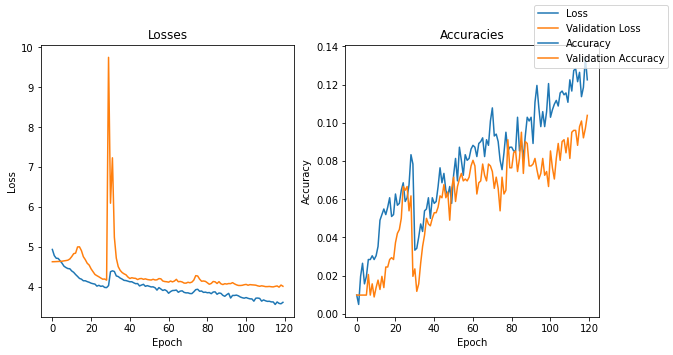

In [13]:
history = {'loss': [4.933203, 4.778612, 4.712742, 4.708459, 4.648549, 4.588217, 4.513692, 4.480162, 4.454505, 4.449397, 4.394504, 4.359779, 4.304623, 4.257103, 4.206994, 4.188591, 4.148404, 4.148549, 4.126994, 4.11091, 4.087538, 4.07413, 4.06407, 4.013563, 4.034152, 4.008312, 4.018239, 3.981055, 3.976682, 4.026988, 4.375055, 4.397504, 4.38144, 4.269544, 4.253957, 4.215819, 4.1906, 4.158627, 4.153378, 4.138384, 4.122829, 4.123641, 4.097038, 4.074889, 4.078626, 4.018622, 4.040771, 4.059194, 4.009147, 4.025974, 4.009773, 3.993738, 3.996207, 3.972915, 3.913933, 3.976903, 3.942168, 3.905067, 3.923758, 3.89599, 3.835392, 3.87707, 3.903397, 3.906101, 3.915708, 3.859696, 3.888864, 3.895969, 3.857346, 3.845021, 3.846014, 3.828249, 3.826698, 3.871985, 3.925412, 3.935275, 3.884717, 3.892021, 3.856905, 3.863206, 3.848062, 3.853007, 3.824827, 3.866418, 3.870789, 3.809691, 3.841761, 3.832773, 3.783296, 3.758727, 3.800392, 3.832429, 3.715098, 3.781051, 3.779994, 3.788924, 3.770988, 3.741774, 3.723493, 3.711463, 3.727117, 3.708482, 3.695006, 3.693289, 3.636789, 3.711948, 3.715095, 3.705999, 3.637983, 3.668371, 3.646361, 3.631687, 3.634435, 3.618837, 3.617585, 3.554697, 3.616818, 3.580964, 3.571679, 3.607831], 'accuracy': [0.009804, 0.004902, 0.019608, 0.026471, 0.015686, 0.019608, 0.028431, 0.028431, 0.030392, 0.028431, 0.030392, 0.035294, 0.04902, 0.051961, 0.054902, 0.051961, 0.055882, 0.060784, 0.05098, 0.051961, 0.062745, 0.056863, 0.057843, 0.064706, 0.068627, 0.058824, 0.060784, 0.067647, 0.083333, 0.078431, 0.033333, 0.034314, 0.040196, 0.047059, 0.043137, 0.053922, 0.054902, 0.060784, 0.05, 0.060784, 0.057843, 0.058824, 0.066667, 0.076471, 0.068627, 0.073529, 0.064706, 0.061765, 0.066667, 0.057843, 0.072549, 0.081373, 0.069608, 0.087255, 0.080392, 0.072549, 0.083333, 0.080392, 0.081373, 0.086275, 0.088235, 0.087255, 0.082353, 0.089216, 0.090196, 0.092157, 0.082353, 0.091176, 0.088235, 0.10098, 0.107843, 0.093137, 0.094118, 0.090196, 0.080392, 0.07549, 0.084314, 0.095098, 0.085294, 0.087255, 0.087255, 0.085294, 0.085294, 0.102941, 0.085294, 0.090196, 0.081373, 0.093137, 0.102941, 0.10098, 0.102941, 0.089216, 0.110784, 0.119608, 0.107843, 0.098039, 0.105882, 0.098039, 0.105882, 0.120588, 0.102941, 0.106863, 0.109804, 0.111765, 0.108824, 0.115686, 0.116667, 0.114706, 0.115686, 0.110784, 0.122549, 0.116667, 0.127451, 0.128431, 0.121569, 0.126471, 0.113725, 0.118627, 0.134314, 0.122549], 'val_loss': [4.62539, 4.62667, 4.629114, 4.631567, 4.634011, 4.638593, 4.647288, 4.654223, 4.66458, 4.693739, 4.75419, 4.82733, 4.840985, 4.996055, 4.998963, 4.904411, 4.752005, 4.677692, 4.587276, 4.541486, 4.446252, 4.37524, 4.306014, 4.275507, 4.24798, 4.216964, 4.18828, 4.192066, 4.163744, 9.749428, 6.092951, 7.23126, 5.240884, 4.715438, 4.50229, 4.409367, 4.355366, 4.322562, 4.297664, 4.242298, 4.204638, 4.224226, 4.21281, 4.208085, 4.178112, 4.200573, 4.204943, 4.184776, 4.19652, 4.180181, 4.172164, 4.16689, 4.18571, 4.168423, 4.172199, 4.203022, 4.197083, 4.142873, 4.12869, 4.12424, 4.113154, 4.141653, 4.1207, 4.142071, 4.184143, 4.12376, 4.131168, 4.118142, 4.090275, 4.089031, 4.110732, 4.098159, 4.114439, 4.164806, 4.276163, 4.268165, 4.189748, 4.136752, 4.142606, 4.132891, 4.098209, 4.060516, 4.081059, 4.130078, 4.121747, 4.080022, 4.126055, 4.071929, 4.053438, 4.074533, 4.065908, 4.078722, 4.076477, 4.101745, 4.070296, 4.046974, 4.031009, 4.029749, 4.034566, 4.048853, 4.05707, 4.036119, 4.051802, 4.045996, 4.042667, 4.037658, 4.020865, 4.010103, 4.022012, 4.013093, 4.001687, 4.001912, 4.006242, 3.998025, 3.994699, 4.008087, 4.018971, 3.987945, 4.041105, 4.010334], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.020588, 0.009804, 0.015686, 0.008824, 0.013725, 0.017647, 0.012745, 0.019608, 0.013725, 0.02451, 0.02451, 0.028431, 0.029412, 0.028431, 0.037255, 0.042157, 0.044118, 0.05, 0.066667, 0.064706, 0.066667, 0.053922, 0.061765, 0.019608, 0.023529, 0.011765, 0.015686, 0.026471, 0.035294, 0.041176, 0.05, 0.047059, 0.046078, 0.05, 0.052941, 0.052941, 0.055882, 0.061765, 0.060784, 0.067647, 0.060784, 0.063725, 0.04902, 0.065686, 0.071569, 0.058824, 0.066667, 0.070588, 0.073529, 0.069608, 0.070588, 0.069608, 0.071569, 0.077451, 0.080392, 0.077451, 0.062745, 0.068627, 0.069608, 0.078431, 0.072549, 0.069608, 0.078431, 0.077451, 0.07451, 0.065686, 0.071569, 0.065686, 0.053922, 0.071569, 0.062745, 0.064706, 0.091176, 0.076471, 0.076471, 0.084314, 0.085294, 0.07451, 0.081373, 0.095098, 0.073529, 0.090196, 0.089216, 0.077451, 0.077451, 0.078431, 0.081373, 0.07549, 0.070588, 0.073529, 0.081373, 0.072549, 0.07451, 0.066667, 0.085294, 0.076471, 0.070588, 0.081373, 0.089216, 0.080392, 0.090196, 0.091176, 0.084314, 0.092157, 0.081373, 0.095098, 0.096078, 0.096078, 0.088235, 0.098039, 0.10098, 0.092157, 0.097059, 0.103922]}

plot_history(history)
print(max(history['accuracy']), ' | ', max(history['val_accuracy']))

## Model 5 (depth=30, skips=[2, 3, 5, 8, 13, 21], heat=1, chill=3, skip_start_depth=10)

0.240196  |  0.137255


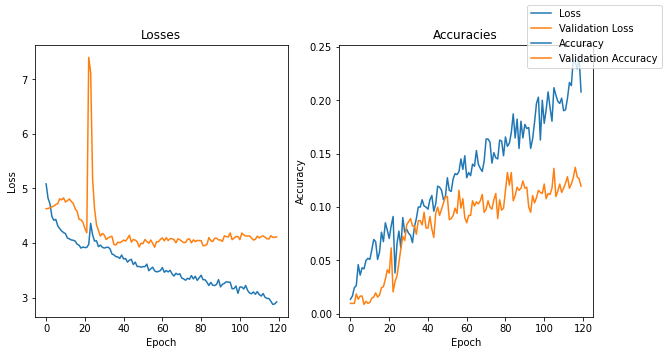

In [14]:
history = {'loss': [5.08202, 4.819621, 4.716983, 4.483245, 4.416396, 4.432909, 4.315057, 4.263754, 4.220068, 4.191669, 4.171094, 4.091025, 4.074702, 4.056173, 4.049688, 4.035142, 3.979259, 3.958887, 3.906689, 3.927642, 3.916417, 3.919084, 3.975762, 4.359375, 4.149557, 4.034146, 4.041173, 3.933278, 3.961383, 3.922744, 3.906954, 3.918675, 3.924459, 3.892485, 3.798182, 3.783285, 3.750587, 3.745043, 3.71676, 3.780182, 3.708059, 3.715294, 3.65002, 3.686789, 3.700323, 3.605301, 3.650727, 3.569188, 3.569695, 3.557832, 3.567948, 3.56724, 3.612507, 3.491871, 3.528569, 3.556596, 3.491038, 3.471278, 3.479214, 3.495702, 3.550088, 3.464159, 3.495129, 3.470653, 3.499215, 3.435348, 3.394361, 3.446206, 3.420403, 3.437433, 3.357577, 3.342773, 3.318233, 3.354416, 3.336018, 3.404278, 3.342278, 3.39087, 3.315174, 3.36144, 3.409714, 3.328965, 3.32656, 3.282478, 3.222616, 3.278791, 3.225756, 3.221463, 3.242636, 3.329258, 3.196331, 3.243092, 3.26086, 3.290672, 3.28424, 3.28024, 3.162009, 3.16485, 3.212407, 3.078687, 3.195147, 3.194067, 3.158886, 3.221695, 3.132141, 3.084609, 3.070798, 3.10358, 3.061512, 3.108913, 3.056469, 3.02902, 3.074347, 3.005686, 2.98518, 2.984784, 2.931827, 2.874935, 2.885488, 2.922639], 'accuracy': [0.013725, 0.016667, 0.02451, 0.026471, 0.046078, 0.036275, 0.043137, 0.042157, 0.05, 0.051961, 0.05098, 0.059804, 0.069608, 0.067647, 0.05098, 0.057843, 0.076471, 0.067647, 0.085294, 0.078431, 0.070588, 0.082353, 0.091176, 0.038235, 0.065686, 0.077451, 0.061765, 0.090196, 0.076471, 0.079412, 0.07549, 0.073529, 0.066667, 0.081373, 0.089216, 0.1, 0.1, 0.106863, 0.10098, 0.1, 0.098039, 0.106863, 0.110784, 0.096078, 0.102941, 0.119608, 0.118627, 0.115686, 0.106863, 0.109804, 0.127451, 0.115686, 0.114706, 0.126471, 0.131373, 0.130392, 0.133333, 0.145098, 0.135294, 0.148039, 0.127451, 0.132353, 0.129412, 0.140196, 0.138235, 0.152941, 0.140196, 0.136275, 0.133333, 0.143137, 0.163725, 0.163725, 0.160784, 0.141176, 0.15098, 0.146078, 0.145098, 0.162745, 0.161765, 0.148039, 0.165686, 0.156863, 0.159804, 0.169608, 0.187255, 0.164706, 0.182353, 0.154902, 0.180392, 0.164706, 0.177451, 0.173529, 0.17451, 0.154902, 0.163725, 0.179412, 0.197059, 0.202941, 0.162745, 0.2, 0.178431, 0.191176, 0.207843, 0.193137, 0.180392, 0.211765, 0.204902, 0.19902, 0.197059, 0.201961, 0.190196, 0.191176, 0.201961, 0.216667, 0.213725, 0.239216, 0.235294, 0.229412, 0.240196, 0.207843], 'val_loss': [4.626829, 4.632754, 4.643215, 4.661314, 4.675892, 4.705829, 4.719478, 4.809616, 4.789927, 4.825948, 4.750421, 4.775087, 4.805618, 4.761539, 4.724574, 4.626783, 4.58021, 4.434513, 4.425264, 4.381207, 4.268774, 4.186358, 7.398898, 7.120559, 5.169884, 4.625681, 4.335425, 4.231638, 4.12731, 4.174619, 4.146463, 4.063861, 4.092452, 4.112526, 4.121077, 3.973517, 3.962801, 4.015025, 4.002467, 4.025596, 4.053897, 4.035242, 4.080892, 4.142901, 4.015429, 4.06359, 4.052771, 4.024175, 3.927985, 3.995973, 3.988003, 4.064321, 4.02897, 3.994488, 4.055334, 3.994421, 3.922415, 4.024814, 4.022743, 4.067485, 4.093081, 4.039825, 4.098719, 4.044085, 4.079669, 4.077246, 4.062093, 4.002919, 4.07676, 4.060016, 4.033825, 4.006979, 4.011385, 4.067197, 4.075503, 4.001678, 4.058403, 4.026282, 4.046602, 4.044794, 4.043406, 3.949922, 3.953758, 3.972687, 4.099406, 4.044067, 4.025789, 4.085836, 4.088439, 4.056159, 4.056087, 4.028655, 4.130606, 4.117023, 4.11008, 4.183101, 4.059671, 4.089977, 4.117671, 4.119698, 4.06254, 4.182285, 4.148942, 4.129984, 4.125878, 4.129038, 4.091982, 4.053788, 4.067334, 4.125665, 4.092779, 4.118197, 4.128987, 4.106688, 4.077177, 4.073472, 4.133739, 4.101246, 4.104944, 4.112055], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.018627, 0.013725, 0.016667, 0.016667, 0.008824, 0.011765, 0.009804, 0.010784, 0.014706, 0.015686, 0.019608, 0.015686, 0.017647, 0.02451, 0.02549, 0.032353, 0.041176, 0.038235, 0.061765, 0.020588, 0.030392, 0.035294, 0.048039, 0.060784, 0.072549, 0.068627, 0.083333, 0.086275, 0.089216, 0.082353, 0.082353, 0.07451, 0.087255, 0.087255, 0.083333, 0.095098, 0.080392, 0.080392, 0.091176, 0.079412, 0.071569, 0.094118, 0.1, 0.092157, 0.098039, 0.103922, 0.109804, 0.109804, 0.088235, 0.089216, 0.092157, 0.09902, 0.094118, 0.115686, 0.09902, 0.107843, 0.090196, 0.085294, 0.092157, 0.092157, 0.105882, 0.10098, 0.104902, 0.102941, 0.105882, 0.111765, 0.095098, 0.098039, 0.105882, 0.1, 0.098039, 0.106863, 0.112745, 0.089216, 0.106863, 0.097059, 0.09902, 0.115686, 0.132353, 0.120588, 0.132353, 0.105882, 0.110784, 0.118627, 0.115686, 0.117647, 0.12451, 0.117647, 0.118627, 0.1, 0.095098, 0.110784, 0.103922, 0.108824, 0.115686, 0.113725, 0.112745, 0.121569, 0.107843, 0.112745, 0.111765, 0.117647, 0.136275, 0.109804, 0.114706, 0.121569, 0.113725, 0.117647, 0.122549, 0.128431, 0.117647, 0.121569, 0.127451, 0.137255, 0.128431, 0.126471, 0.119608]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 6 (depth=60, skips=[2, 3, 5, 8, 13, 21], heat=1, chill=2, reheat=7, skip_start_depth=10)

0.036275 | 0.037255


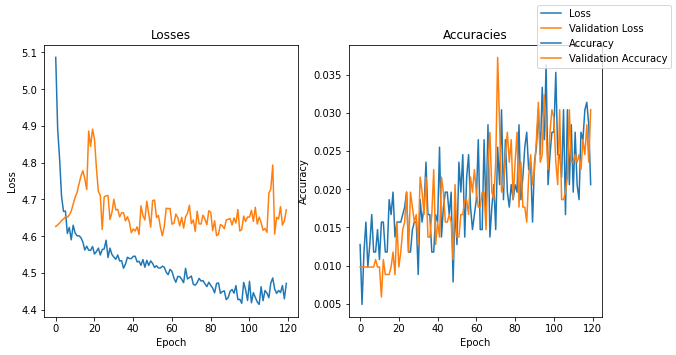

In [15]:
history = {'loss': [5.086607, 4.891028, 4.8105, 4.708412, 4.667637, 4.668048, 4.607385, 4.623818, 4.590005, 4.629722, 4.608683, 4.600798, 4.601169, 4.59583, 4.584163, 4.56228, 4.572638, 4.561872, 4.561254, 4.571932, 4.551338, 4.557903, 4.567478, 4.548749, 4.563562, 4.565157, 4.588894, 4.541884, 4.5674, 4.55, 4.543119, 4.536981, 4.548764, 4.532374, 4.533117, 4.512661, 4.524113, 4.542648, 4.53928, 4.538929, 4.545011, 4.545416, 4.530054, 4.531574, 4.520584, 4.536413, 4.51542, 4.534223, 4.520367, 4.532617, 4.525941, 4.514729, 4.51959, 4.513301, 4.513412, 4.51804, 4.515697, 4.501948, 4.495141, 4.509619, 4.503923, 4.48602, 4.474618, 4.490482, 4.489851, 4.48263, 4.473358, 4.512384, 4.483433, 4.487516, 4.4915, 4.469053, 4.466578, 4.473519, 4.484977, 4.477784, 4.478937, 4.470525, 4.462652, 4.474607, 4.466379, 4.458621, 4.445833, 4.471166, 4.472764, 4.444281, 4.449082, 4.451083, 4.427259, 4.432781, 4.449745, 4.454885, 4.444834, 4.465352, 4.427247, 4.42814, 4.417213, 4.474117, 4.453881, 4.424933, 4.476944, 4.418689, 4.44616, 4.433253, 4.421053, 4.414151, 4.46243, 4.424349, 4.452108, 4.445038, 4.432463, 4.472701, 4.486156, 4.456181, 4.444152, 4.452184, 4.44653, 4.465623, 4.429575, 4.471505], 'accuracy': [0.012745, 0.004902, 0.011765, 0.015686, 0.009804, 0.012745, 0.016667, 0.011765, 0.011765, 0.014706, 0.010784, 0.015686, 0.015686, 0.011765, 0.011765, 0.018627, 0.016667, 0.019608, 0.013725, 0.015686, 0.015686, 0.015686, 0.016667, 0.017647, 0.019608, 0.011765, 0.011765, 0.014706, 0.015686, 0.015686, 0.008824, 0.018627, 0.015686, 0.017647, 0.023529, 0.016667, 0.016667, 0.011765, 0.011765, 0.016667, 0.015686, 0.02549, 0.013725, 0.017647, 0.019608, 0.019608, 0.016667, 0.019608, 0.007843, 0.017647, 0.012745, 0.023529, 0.019608, 0.02451, 0.013725, 0.021569, 0.02451, 0.017647, 0.014706, 0.016667, 0.018627, 0.026471, 0.014706, 0.014706, 0.026471, 0.016667, 0.028431, 0.013725, 0.017647, 0.020588, 0.014706, 0.02549, 0.020588, 0.030392, 0.018627, 0.026471, 0.019608, 0.017647, 0.020588, 0.018627, 0.020588, 0.019608, 0.028431, 0.018627, 0.021569, 0.02549, 0.027451, 0.022549, 0.023529, 0.015686, 0.023529, 0.02549, 0.030392, 0.02451, 0.033333, 0.026471, 0.036275, 0.020588, 0.02451, 0.027451, 0.027451, 0.035294, 0.02451, 0.02451, 0.021569, 0.030392, 0.016667, 0.030392, 0.020588, 0.028431, 0.019608, 0.027451, 0.020588, 0.018627, 0.027451, 0.026471, 0.030392, 0.031373, 0.028431, 0.020588], 'val_loss': [4.626326, 4.63062, 4.635654, 4.642103, 4.646683, 4.652645, 4.651061, 4.657796, 4.667763, 4.686968, 4.705644, 4.718877, 4.741728, 4.763182, 4.778108, 4.756696, 4.726862, 4.886054, 4.843894, 4.891243, 4.863743, 4.785094, 4.722126, 4.71072, 4.618298, 4.706527, 4.710077, 4.71031, 4.645178, 4.664491, 4.700613, 4.671383, 4.672904, 4.652552, 4.663566, 4.663706, 4.641615, 4.652676, 4.638361, 4.609532, 4.619546, 4.613894, 4.62533, 4.604316, 4.682426, 4.656075, 4.644166, 4.695048, 4.660466, 4.62442, 4.696877, 4.698255, 4.65069, 4.656452, 4.625062, 4.601114, 4.625152, 4.676119, 4.674817, 4.675453, 4.632724, 4.634773, 4.659993, 4.650397, 4.628004, 4.651185, 4.621832, 4.65242, 4.662443, 4.684025, 4.634041, 4.644066, 4.612929, 4.667909, 4.633537, 4.633047, 4.657104, 4.646379, 4.630963, 4.669167, 4.664824, 4.614663, 4.641692, 4.601323, 4.605618, 4.631657, 4.628471, 4.620119, 4.643978, 4.6459, 4.647717, 4.630309, 4.649545, 4.635818, 4.672568, 4.613959, 4.618248, 4.654753, 4.639708, 4.652062, 4.651803, 4.670183, 4.640388, 4.678689, 4.633212, 4.651684, 4.637454, 4.615968, 4.620916, 4.610462, 4.717381, 4.728336, 4.793654, 4.605659, 4.651418, 4.646565, 4.68029, 4.630121, 4.641466, 4.671687], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.009804, 0.009804, 0.005882, 0.010784, 0.008824, 0.008824, 0.008824, 0.009804, 0.011765, 0.008824, 0.015686, 0.009804, 0.011765, 0.014706, 0.015686, 0.019608, 0.011765, 0.019608, 0.017647, 0.015686, 0.016667, 0.012745, 0.021569, 0.019608, 0.016667, 0.021569, 0.013725, 0.013725, 0.016667, 0.022549, 0.012745, 0.015686, 0.013725, 0.021569, 0.019608, 0.015686, 0.015686, 0.016667, 0.015686, 0.010784, 0.020588, 0.013725, 0.013725, 0.016667, 0.016667, 0.018627, 0.018627, 0.016667, 0.021569, 0.019608, 0.022549, 0.019608, 0.017647, 0.017647, 0.019608, 0.019608, 0.014706, 0.023529, 0.027451, 0.019608, 0.018627, 0.023529, 0.037255, 0.028431, 0.019608, 0.020588, 0.02451, 0.027451, 0.023529, 0.026471, 0.018627, 0.023529, 0.027451, 0.017647, 0.023529, 0.017647, 0.017647, 0.015686, 0.021569, 0.02451, 0.020588, 0.022549, 0.026471, 0.031373, 0.023529, 0.02451, 0.032353, 0.027451, 0.022549, 0.027451, 0.030392, 0.029412, 0.023529, 0.020588, 0.030392, 0.018627, 0.018627, 0.019608, 0.021569, 0.030392, 0.023529, 0.023529, 0.02451, 0.023529, 0.02451, 0.022549, 0.026471, 0.02451, 0.028431, 0.023529, 0.030392]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 7 (depth=30, skips=[2, 3, 5, 8, 13, 21])

0.134314 | 0.094118


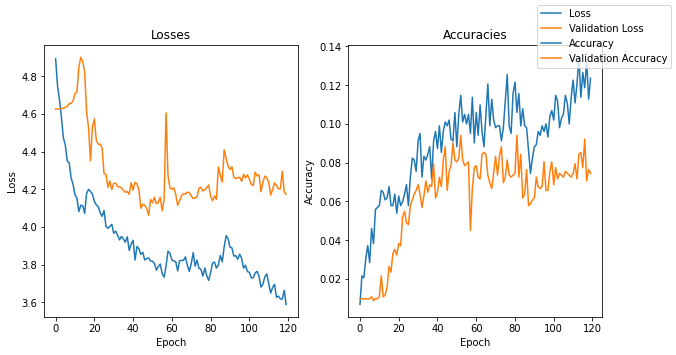

In [16]:
history = {'loss': [4.89319, 4.748472, 4.674715, 4.581836, 4.474596, 4.435531, 4.350806, 4.341587, 4.260673, 4.226339, 4.171782, 4.153233, 4.082014, 4.115816, 4.112966, 4.072747, 4.179003, 4.199831, 4.188788, 4.175401, 4.136713, 4.117488, 4.108925, 4.076506, 4.05667, 4.087366, 4.003995, 3.993302, 4.003372, 4.013997, 3.967226, 3.978596, 3.956987, 3.932001, 3.950158, 3.935851, 3.919649, 3.948306, 3.875764, 3.909902, 3.92994, 3.825122, 3.897415, 3.884278, 3.855343, 3.866032, 3.824916, 3.832913, 3.835671, 3.820174, 3.818907, 3.806987, 3.771234, 3.790526, 3.803489, 3.752725, 3.734184, 3.791926, 3.872354, 3.861012, 3.826539, 3.818668, 3.816846, 3.767223, 3.821784, 3.823178, 3.823016, 3.841707, 3.796979, 3.765137, 3.805636, 3.864723, 3.792702, 3.824722, 3.781343, 3.776093, 3.739763, 3.782628, 3.741928, 3.716815, 3.758336, 3.809286, 3.814099, 3.782213, 3.798878, 3.849283, 3.815409, 3.894301, 3.954411, 3.939066, 3.893346, 3.889401, 3.846056, 3.847886, 3.830166, 3.856184, 3.834092, 3.782107, 3.79715, 3.763752, 3.759734, 3.730277, 3.730864, 3.756003, 3.765157, 3.737581, 3.681499, 3.697661, 3.736296, 3.751325, 3.699051, 3.649718, 3.679616, 3.696214, 3.627156, 3.633719, 3.618989, 3.617933, 3.664513, 3.589396], 'accuracy': [0.006863, 0.021569, 0.020588, 0.030392, 0.037255, 0.028431, 0.046078, 0.038235, 0.055882, 0.056863, 0.057843, 0.065686, 0.064706, 0.060784, 0.061765, 0.067647, 0.057843, 0.057843, 0.063725, 0.053922, 0.062745, 0.057843, 0.059804, 0.063725, 0.068627, 0.057843, 0.072549, 0.082353, 0.081373, 0.07549, 0.091176, 0.095098, 0.072549, 0.083333, 0.081373, 0.084314, 0.088235, 0.071569, 0.091176, 0.096078, 0.087255, 0.09902, 0.085294, 0.096078, 0.10098, 0.09902, 0.101961, 0.092157, 0.091176, 0.105882, 0.088235, 0.104902, 0.114706, 0.10098, 0.104902, 0.1, 0.104902, 0.095098, 0.113725, 0.090196, 0.105882, 0.094118, 0.109804, 0.096078, 0.088235, 0.104902, 0.120588, 0.09902, 0.112745, 0.101961, 0.098039, 0.09902, 0.09902, 0.091176, 0.098039, 0.111765, 0.12549, 0.09902, 0.095098, 0.115686, 0.121569, 0.105882, 0.115686, 0.09902, 0.107843, 0.09902, 0.098039, 0.086275, 0.07451, 0.082353, 0.088235, 0.089216, 0.096078, 0.094118, 0.09902, 0.096078, 0.1, 0.093137, 0.103922, 0.106863, 0.101961, 0.114706, 0.111765, 0.098039, 0.102941, 0.104902, 0.114706, 0.110784, 0.1, 0.113725, 0.122549, 0.110784, 0.120588, 0.134314, 0.113725, 0.126471, 0.118627, 0.132353, 0.112745, 0.123529], 'val_loss': [4.625312, 4.626233, 4.627368, 4.628398, 4.630377, 4.634328, 4.64099, 4.654519, 4.655835, 4.6695, 4.708912, 4.715391, 4.849381, 4.900312, 4.877799, 4.822409, 4.611162, 4.526411, 4.351426, 4.531445, 4.573833, 4.460775, 4.439425, 4.440091, 4.419261, 4.283057, 4.278862, 4.210562, 4.24494, 4.19893, 4.231928, 4.23245, 4.21445, 4.213881, 4.207698, 4.194581, 4.184648, 4.18801, 4.173934, 4.23514, 4.196141, 4.237589, 4.229328, 4.196502, 4.099384, 4.120906, 4.116441, 4.099752, 4.062182, 4.146082, 4.128891, 4.158196, 4.124437, 4.130949, 4.158114, 4.085565, 4.14671, 4.605816, 4.275327, 4.208591, 4.200085, 4.208328, 4.173362, 4.115704, 4.139313, 4.165803, 4.177214, 4.175583, 4.184608, 4.1838, 4.165493, 4.150487, 4.154879, 4.160483, 4.206968, 4.211187, 4.191308, 4.197796, 4.208929, 4.223096, 4.161884, 4.139555, 4.164786, 4.146377, 4.317959, 4.27507, 4.238742, 4.409851, 4.363943, 4.324187, 4.305372, 4.320487, 4.264472, 4.256396, 4.2624, 4.2639, 4.243307, 4.279937, 4.261032, 4.277226, 4.253881, 4.227236, 4.220273, 4.291605, 4.271335, 4.276573, 4.187117, 4.238476, 4.270308, 4.261165, 4.236718, 4.169761, 4.198946, 4.234412, 4.2195, 4.203311, 4.202725, 4.296415, 4.185305, 4.174029], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.008824, 0.009804, 0.009804, 0.010784, 0.021569, 0.010784, 0.011765, 0.015686, 0.026471, 0.023529, 0.033333, 0.035294, 0.032353, 0.038235, 0.037255, 0.051961, 0.054902, 0.04902, 0.048039, 0.057843, 0.060784, 0.063725, 0.065686, 0.068627, 0.063725, 0.056863, 0.062745, 0.070588, 0.064706, 0.068627, 0.067647, 0.079412, 0.061765, 0.064706, 0.072549, 0.067647, 0.081373, 0.088235, 0.065686, 0.07549, 0.078431, 0.090196, 0.081373, 0.080392, 0.082353, 0.094118, 0.081373, 0.078431, 0.079412, 0.080392, 0.045098, 0.066667, 0.077451, 0.078431, 0.072549, 0.071569, 0.084314, 0.085294, 0.084314, 0.073529, 0.069608, 0.066667, 0.07451, 0.083333, 0.073529, 0.083333, 0.088235, 0.069608, 0.072549, 0.081373, 0.073529, 0.072549, 0.073529, 0.07451, 0.094118, 0.072549, 0.084314, 0.061765, 0.063725, 0.076471, 0.057843, 0.058824, 0.060784, 0.061765, 0.072549, 0.067647, 0.066667, 0.067647, 0.080392, 0.065686, 0.065686, 0.07549, 0.080392, 0.068627, 0.077451, 0.071569, 0.07451, 0.073529, 0.072549, 0.07549, 0.07451, 0.073529, 0.072549, 0.07451, 0.079412, 0.071569, 0.084314, 0.085294, 0.077451, 0.092157, 0.070588, 0.076471, 0.07451]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 8 (depth=30, skips=[2, 3, 5, 8, 13, 21])

0.041176 | 0.035294


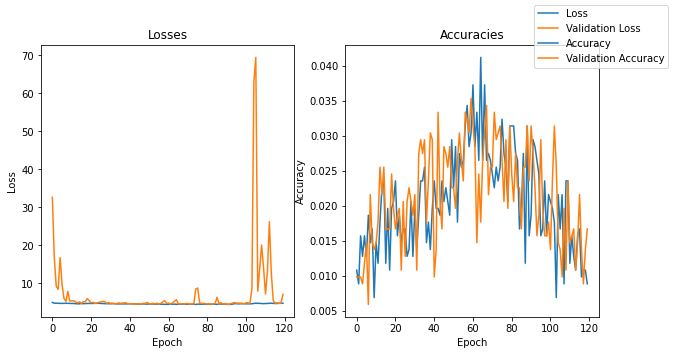

In [17]:
history = {'loss': [5.018319, 4.779753, 4.802488, 4.775996, 4.74552, 4.758286, 4.744069, 4.775954, 4.760247, 4.742341, 4.722905, 4.740964, 4.649823, 4.641815, 4.636615, 4.707096, 4.67471, 4.691229, 4.730086, 4.740242, 4.725834, 4.740756, 4.752261, 4.759723, 4.780746, 4.726988, 4.710612, 4.678868, 4.666587, 4.670634, 4.638478, 4.673852, 4.689576, 4.604233, 4.620131, 4.601905, 4.62193, 4.597948, 4.611623, 4.629493, 4.646375, 4.59472, 4.618809, 4.574564, 4.581422, 4.564669, 4.563642, 4.610848, 4.580721, 4.552442, 4.593291, 4.557953, 4.609929, 4.500214, 4.57601, 4.555871, 4.510363, 4.53485, 4.491439, 4.482675, 4.515558, 4.555814, 4.524419, 4.549991, 4.494314, 4.528429, 4.542193, 4.540282, 4.541557, 4.527471, 4.540826, 4.521359, 4.522701, 4.535301, 4.467257, 4.559382, 4.540923, 4.506108, 4.564288, 4.514729, 4.507807, 4.524325, 4.481069, 4.542775, 4.521578, 4.500359, 4.59283, 4.576167, 4.538449, 4.605937, 4.502556, 4.494589, 4.480803, 4.543866, 4.686048, 4.642325, 4.626705, 4.637412, 4.667173, 4.652041, 4.63263, 4.63566, 4.626862, 4.650987, 4.732451, 4.787997, 4.760582, 4.753429, 4.714588, 4.670189, 4.708257, 4.738136, 4.756654, 4.81454, 4.732295, 4.73491, 4.709717, 4.782801, 4.777371, 4.790549], 'accuracy': [0.010784, 0.008824, 0.015686, 0.012745, 0.015686, 0.012745, 0.018627, 0.014706, 0.016667, 0.006863, 0.014706, 0.011765, 0.017647, 0.022549, 0.023529, 0.011765, 0.019608, 0.010784, 0.019608, 0.020588, 0.023529, 0.015686, 0.018627, 0.014706, 0.016667, 0.016667, 0.012745, 0.013725, 0.020588, 0.012745, 0.019608, 0.013725, 0.018627, 0.023529, 0.023529, 0.02549, 0.014706, 0.017647, 0.013725, 0.019608, 0.023529, 0.019608, 0.019608, 0.018627, 0.023529, 0.020588, 0.022549, 0.020588, 0.018627, 0.029412, 0.022549, 0.028431, 0.017647, 0.027451, 0.02549, 0.026471, 0.031373, 0.034314, 0.028431, 0.030392, 0.037255, 0.028431, 0.033333, 0.026471, 0.041176, 0.026471, 0.037255, 0.026471, 0.027451, 0.026471, 0.02451, 0.022549, 0.02549, 0.023529, 0.02549, 0.032353, 0.027451, 0.02549, 0.020588, 0.031373, 0.031373, 0.031373, 0.027451, 0.026471, 0.016667, 0.019608, 0.027451, 0.011765, 0.031373, 0.015686, 0.018627, 0.029412, 0.028431, 0.026471, 0.02451, 0.015686, 0.016667, 0.023529, 0.015686, 0.021569, 0.020588, 0.019608, 0.017647, 0.006863, 0.021569, 0.016667, 0.021569, 0.008824, 0.023529, 0.023529, 0.011765, 0.015686, 0.012745, 0.010784, 0.015686, 0.016667, 0.009804, 0.010784, 0.010784, 0.008824], 'val_loss': [32.647339, 16.852898, 9.305022, 8.426834, 16.759232, 9.794376, 6.063621, 5.256626, 7.928391, 5.362111, 5.441419, 5.448738, 5.141125, 4.86142, 5.158536, 4.721582, 5.194083, 5.174717, 6.01574, 5.48115, 4.901421, 5.002525, 4.777328, 4.831126, 5.034332, 5.135834, 5.267183, 5.211328, 4.752306, 4.960628, 4.774394, 4.813505, 4.66797, 4.592009, 4.895043, 4.751924, 4.803123, 4.866985, 4.902477, 4.668949, 4.658471, 4.700261, 4.582715, 4.586608, 4.57607, 4.649817, 4.58282, 4.764093, 4.785077, 4.982596, 4.662374, 4.57453, 4.78883, 4.589334, 4.809214, 4.569542, 4.736009, 5.182258, 5.430211, 4.759276, 4.838012, 4.569517, 4.85003, 5.298418, 5.728078, 4.640728, 4.650486, 4.654794, 4.579152, 4.708127, 4.706294, 4.5505, 4.623923, 4.583755, 8.499419, 8.788205, 4.927567, 4.699174, 4.766953, 4.657785, 4.583264, 4.582983, 4.580199, 4.614234, 4.696314, 6.344117, 4.638328, 4.926001, 4.577174, 4.735002, 4.560447, 4.480626, 4.657842, 4.845149, 4.924364, 4.823381, 4.812016, 4.777755, 4.792552, 4.650595, 4.90894, 4.853524, 4.795535, 8.581131, 63.020199, 69.444809, 7.944332, 13.740808, 20.098265, 14.075443, 7.198413, 13.093271, 26.242802, 12.700982, 5.479875, 4.81461, 4.889169, 4.746357, 4.761895, 7.134878], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.008824, 0.011765, 0.014706, 0.005882, 0.021569, 0.014706, 0.013725, 0.014706, 0.017647, 0.02549, 0.021569, 0.02549, 0.016667, 0.016667, 0.016667, 0.02451, 0.019608, 0.016667, 0.018627, 0.019608, 0.010784, 0.020588, 0.012745, 0.020588, 0.022549, 0.020588, 0.018627, 0.021569, 0.010784, 0.027451, 0.029412, 0.027451, 0.029412, 0.017647, 0.023529, 0.030392, 0.029412, 0.009804, 0.013725, 0.033333, 0.020588, 0.016667, 0.028431, 0.027451, 0.02549, 0.028431, 0.022549, 0.022549, 0.019608, 0.026471, 0.030392, 0.026471, 0.023529, 0.033333, 0.032353, 0.030392, 0.035294, 0.031373, 0.028431, 0.014706, 0.02451, 0.017647, 0.026471, 0.030392, 0.034314, 0.021569, 0.02549, 0.02549, 0.033333, 0.029412, 0.030392, 0.031373, 0.026471, 0.020588, 0.029412, 0.019608, 0.031373, 0.02451, 0.020588, 0.027451, 0.022549, 0.022549, 0.016667, 0.02549, 0.02549, 0.031373, 0.023529, 0.031373, 0.027451, 0.022549, 0.015686, 0.018627, 0.029412, 0.019608, 0.015686, 0.015686, 0.017647, 0.013725, 0.023529, 0.031373, 0.02549, 0.014706, 0.013725, 0.009804, 0.019608, 0.010784, 0.023529, 0.014706, 0.015686, 0.016667, 0.010784, 0.014706, 0.021569, 0.013725, 0.008824, 0.013725, 0.016667]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 10 (depth=20, skips=[2, 3, 5, 8, 13])

0.182353 | 0.083333


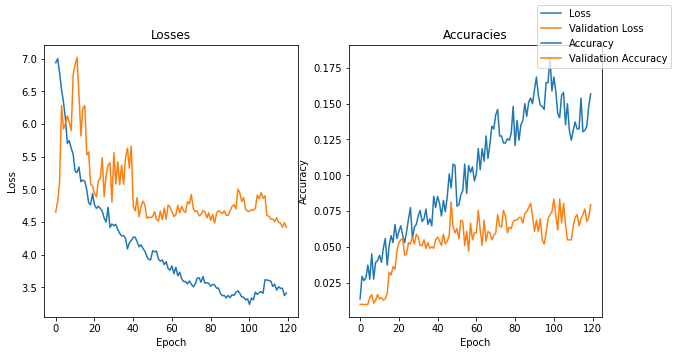

In [18]:
history = {'loss': [6.940204, 7.002898, 6.784101, 6.526034, 6.339378, 6.080689, 5.702124, 5.745649, 5.627224, 5.536824, 5.274893, 5.257538, 5.342301, 5.116095, 5.140645, 5.121687, 4.993644, 4.794036, 4.761634, 4.935325, 4.762495, 4.707802, 4.740272, 4.708177, 4.664823, 4.559032, 4.496655, 4.72429, 4.4165, 4.468568, 4.442174, 4.462479, 4.383713, 4.324912, 4.287296, 4.289674, 4.250465, 4.086909, 4.180121, 4.213561, 4.265695, 4.266548, 4.19797, 4.120072, 4.150098, 4.094834, 4.051987, 3.971443, 3.925952, 3.919888, 4.057845, 4.041041, 4.053149, 3.932688, 3.899347, 3.918228, 3.844831, 3.890835, 3.786227, 3.760092, 3.825287, 3.706306, 3.805942, 3.672983, 3.728793, 3.62766, 3.586881, 3.586058, 3.550383, 3.594558, 3.54523, 3.506837, 3.548215, 3.639202, 3.642845, 3.576254, 3.663532, 3.560896, 3.567774, 3.559167, 3.515053, 3.54264, 3.534796, 3.482798, 3.486548, 3.40355, 3.369373, 3.373264, 3.335808, 3.372968, 3.340362, 3.385139, 3.373716, 3.422683, 3.444773, 3.406734, 3.349534, 3.345654, 3.305927, 3.322388, 3.235415, 3.334422, 3.304423, 3.424141, 3.389128, 3.416719, 3.43182, 3.406692, 3.614195, 3.608709, 3.60321, 3.592753, 3.512208, 3.546088, 3.455436, 3.506756, 3.482839, 3.483637, 3.371015, 3.408784], 'accuracy': [0.013725, 0.029412, 0.026471, 0.028431, 0.037255, 0.027451, 0.045098, 0.027451, 0.039216, 0.040196, 0.044118, 0.039216, 0.04902, 0.055882, 0.037255, 0.05098, 0.057843, 0.052941, 0.065686, 0.055882, 0.060784, 0.064706, 0.057843, 0.052941, 0.060784, 0.069608, 0.077451, 0.055882, 0.063725, 0.065686, 0.071569, 0.07549, 0.067647, 0.069608, 0.076471, 0.065686, 0.069608, 0.064706, 0.085294, 0.077451, 0.085294, 0.080392, 0.071569, 0.082353, 0.07451, 0.085294, 0.10098, 0.091176, 0.107843, 0.106863, 0.078431, 0.079412, 0.086275, 0.089216, 0.107843, 0.087255, 0.106863, 0.101961, 0.105882, 0.096078, 0.10098, 0.118627, 0.103922, 0.118627, 0.109804, 0.127451, 0.111765, 0.121569, 0.134314, 0.132353, 0.142157, 0.146078, 0.127451, 0.127451, 0.122549, 0.122549, 0.12549, 0.12451, 0.129412, 0.148039, 0.120588, 0.138235, 0.12451, 0.135294, 0.138235, 0.15, 0.141176, 0.15098, 0.153922, 0.15, 0.159804, 0.168627, 0.155882, 0.14902, 0.148039, 0.146078, 0.164706, 0.164706, 0.182353, 0.158824, 0.168627, 0.158824, 0.143137, 0.140196, 0.155882, 0.157843, 0.135294, 0.15, 0.131373, 0.12451, 0.131373, 0.137255, 0.132353, 0.132353, 0.153922, 0.130392, 0.131373, 0.134314, 0.148039, 0.156863], 'val_loss': [4.651115, 4.814884, 5.115777, 6.284649, 5.923137, 6.007481, 6.125083, 6.031417, 5.903734, 6.75604, 6.908544, 7.022505, 6.452855, 5.817385, 6.245041, 6.286623, 5.52632, 5.572699, 5.078659, 5.050117, 4.937332, 4.882754, 5.134053, 5.171484, 5.483562, 4.889366, 5.219658, 5.368108, 5.406523, 4.803712, 5.56194, 5.084082, 5.421613, 5.072665, 5.371349, 5.074384, 5.475353, 5.631331, 5.322906, 5.663823, 4.743503, 4.669759, 4.874737, 4.579206, 4.730824, 4.81766, 4.765118, 4.556639, 4.575018, 4.566443, 4.579643, 4.657675, 4.539955, 4.513513, 4.66374, 4.535061, 4.712255, 4.54031, 4.757336, 4.730162, 4.65991, 4.583112, 4.609755, 4.753982, 4.639436, 4.739721, 4.670716, 4.644306, 4.811457, 4.776536, 4.920889, 4.702613, 4.659714, 4.670702, 4.593781, 4.61336, 4.675054, 4.655025, 4.561477, 4.639565, 4.524003, 4.616895, 4.482769, 4.632099, 4.671894, 4.654536, 4.626021, 4.671453, 4.602194, 4.599741, 4.676706, 4.736252, 4.765104, 4.698506, 5.001764, 4.943662, 4.8141, 4.87464, 4.689519, 4.664718, 4.659949, 4.688707, 4.678889, 4.706817, 4.908169, 4.853237, 4.950951, 4.859975, 4.90093, 4.598701, 4.586836, 4.541528, 4.544498, 4.504681, 4.566061, 4.494113, 4.481194, 4.418008, 4.489461, 4.417152], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.014706, 0.016667, 0.010784, 0.012745, 0.016667, 0.013725, 0.014706, 0.012745, 0.013725, 0.017647, 0.032353, 0.030392, 0.036275, 0.034314, 0.047059, 0.052941, 0.054902, 0.055882, 0.044118, 0.045098, 0.052941, 0.051961, 0.056863, 0.051961, 0.058824, 0.056863, 0.05098, 0.05098, 0.054902, 0.04902, 0.052941, 0.04902, 0.05, 0.04902, 0.054902, 0.056863, 0.053922, 0.05098, 0.058824, 0.051961, 0.053922, 0.057843, 0.081373, 0.063725, 0.059804, 0.062745, 0.055882, 0.068627, 0.067647, 0.05098, 0.060784, 0.047059, 0.066667, 0.054902, 0.059804, 0.059804, 0.07549, 0.061765, 0.05098, 0.068627, 0.053922, 0.060784, 0.059804, 0.054902, 0.057843, 0.059804, 0.072549, 0.064706, 0.063725, 0.07549, 0.071569, 0.059804, 0.063725, 0.062745, 0.067647, 0.068627, 0.068627, 0.070588, 0.070588, 0.066667, 0.073529, 0.07451, 0.077451, 0.080392, 0.071569, 0.060784, 0.068627, 0.060784, 0.069608, 0.054902, 0.051961, 0.059804, 0.069608, 0.072549, 0.07451, 0.083333, 0.072549, 0.061765, 0.083333, 0.066667, 0.080392, 0.065686, 0.054902, 0.054902, 0.054902, 0.064706, 0.070588, 0.072549, 0.064706, 0.069608, 0.072549, 0.076471, 0.067647, 0.070588, 0.079412]}
plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 11 (depth=30, skips=[2, 3, 5, 8, 13, 21])
* Uses Conv Merge

0.079412 | 0.055882


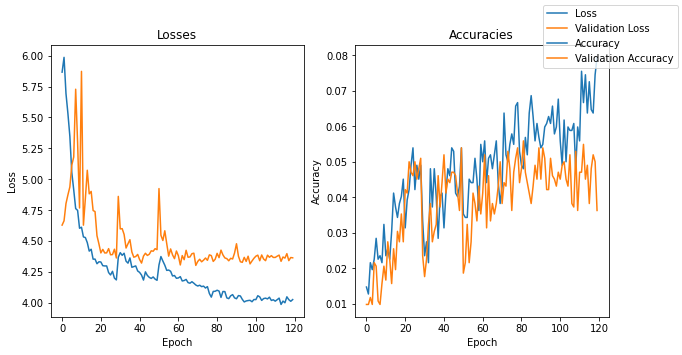

In [19]:
history = {'loss': [5.866611, 5.986466, 5.693815, 5.531745, 5.348197, 5.0545, 4.914179, 4.762941, 4.748116, 4.603439, 4.611916, 4.533374, 4.528438, 4.486985, 4.418464, 4.433768, 4.353338, 4.353845, 4.316489, 4.332121, 4.330582, 4.30052, 4.298563, 4.298521, 4.245007, 4.225518, 4.254998, 4.199982, 4.185589, 4.3685, 4.406151, 4.384432, 4.401584, 4.337368, 4.321167, 4.363352, 4.287633, 4.293253, 4.298619, 4.257904, 4.246351, 4.224438, 4.184179, 4.250708, 4.221687, 4.205845, 4.197616, 4.209483, 4.191937, 4.182221, 4.306802, 4.374598, 4.338168, 4.304595, 4.262655, 4.265309, 4.255359, 4.217422, 4.220952, 4.198682, 4.201245, 4.212051, 4.176865, 4.18054, 4.189457, 4.163688, 4.158689, 4.170909, 4.1587, 4.14431, 4.136045, 4.142623, 4.131215, 4.135197, 4.11981, 4.131111, 4.075687, 4.046198, 4.09236, 4.093594, 4.101944, 4.095336, 4.04395, 4.09168, 4.090886, 4.040012, 4.033986, 4.056805, 4.066476, 4.040143, 4.033004, 4.058699, 4.055569, 4.028018, 4.007383, 4.015224, 4.01852, 4.020333, 4.00886, 4.026878, 4.026116, 4.057587, 4.047835, 4.01969, 4.03443, 4.037948, 4.031868, 4.045723, 4.01938, 4.024822, 4.013637, 4.025424, 4.0383, 3.986954, 4.014225, 4.000497, 4.048674, 4.025579, 4.012519, 4.026234], 'accuracy': [0.014706, 0.012745, 0.021569, 0.019608, 0.022549, 0.028431, 0.022549, 0.023529, 0.021569, 0.032353, 0.023529, 0.02549, 0.022549, 0.030392, 0.041176, 0.037255, 0.034314, 0.038235, 0.040196, 0.045098, 0.031373, 0.039216, 0.042157, 0.04902, 0.053922, 0.042157, 0.04902, 0.045098, 0.04902, 0.033333, 0.023529, 0.027451, 0.021569, 0.048039, 0.037255, 0.048039, 0.040196, 0.028431, 0.040196, 0.041176, 0.031373, 0.041176, 0.048039, 0.046078, 0.053922, 0.052941, 0.041176, 0.040196, 0.043137, 0.053922, 0.035294, 0.034314, 0.034314, 0.045098, 0.044118, 0.044118, 0.05098, 0.045098, 0.036275, 0.054902, 0.05, 0.055882, 0.044118, 0.05098, 0.051961, 0.048039, 0.051961, 0.055882, 0.044118, 0.038235, 0.043137, 0.063725, 0.051961, 0.05, 0.054902, 0.057843, 0.054902, 0.065686, 0.066667, 0.052941, 0.04902, 0.048039, 0.056863, 0.051961, 0.063725, 0.068627, 0.062745, 0.055882, 0.060784, 0.056863, 0.053922, 0.054902, 0.059804, 0.060784, 0.062745, 0.060784, 0.065686, 0.057843, 0.059804, 0.067647, 0.055882, 0.04902, 0.061765, 0.05, 0.059804, 0.058824, 0.058824, 0.060784, 0.048039, 0.059804, 0.055882, 0.07549, 0.066667, 0.07451, 0.063725, 0.072549, 0.064706, 0.063725, 0.07451, 0.079412], 'val_loss': [4.628933, 4.663774, 4.80317, 4.873614, 4.937685, 5.114433, 5.180275, 5.72859, 5.296259, 4.76743, 5.87298, 4.628457, 4.843412, 5.073045, 4.882081, 4.901689, 4.746908, 4.738619, 4.543138, 4.477118, 4.40391, 4.432523, 4.403654, 4.404356, 4.438665, 4.388883, 4.390574, 4.433818, 4.362976, 4.861298, 4.598218, 4.600385, 4.553518, 4.443452, 4.478133, 4.51095, 4.411345, 4.369209, 4.374806, 4.391713, 4.350201, 4.321772, 4.378219, 4.401244, 4.383451, 4.393385, 4.420859, 4.41774, 4.438173, 4.430201, 4.92458, 4.546896, 4.504485, 4.583047, 4.4791, 4.37794, 4.436018, 4.388044, 4.357508, 4.419444, 4.381517, 4.306558, 4.382335, 4.349058, 4.425268, 4.368777, 4.371519, 4.397568, 4.401779, 4.302866, 4.334894, 4.352465, 4.332059, 4.345401, 4.362664, 4.343892, 4.388277, 4.382218, 4.335007, 4.352758, 4.400578, 4.365473, 4.426558, 4.387881, 4.363371, 4.357911, 4.340279, 4.360326, 4.354974, 4.403349, 4.478178, 4.377765, 4.332533, 4.327694, 4.36794, 4.335213, 4.377372, 4.31506, 4.338732, 4.360327, 4.377596, 4.385763, 4.340635, 4.387261, 4.354486, 4.341194, 4.385799, 4.368563, 4.381855, 4.367323, 4.367476, 4.377456, 4.386176, 4.335989, 4.370876, 4.362085, 4.397976, 4.341549, 4.366626, 4.364275], 'val_accuracy': [0.009804, 0.009804, 0.011765, 0.009804, 0.021569, 0.020588, 0.010784, 0.009804, 0.015686, 0.020588, 0.016667, 0.027451, 0.022549, 0.015686, 0.02549, 0.019608, 0.030392, 0.027451, 0.035294, 0.027451, 0.042157, 0.041176, 0.05, 0.047059, 0.046078, 0.05, 0.045098, 0.048039, 0.05098, 0.023529, 0.017647, 0.022549, 0.032353, 0.038235, 0.027451, 0.030392, 0.032353, 0.046078, 0.037255, 0.044118, 0.051961, 0.041176, 0.045098, 0.044118, 0.047059, 0.047059, 0.046078, 0.041176, 0.036275, 0.053922, 0.018627, 0.021569, 0.032353, 0.021569, 0.027451, 0.041176, 0.038235, 0.033333, 0.043137, 0.035294, 0.041176, 0.051961, 0.031373, 0.046078, 0.033333, 0.038235, 0.035294, 0.038235, 0.043137, 0.05, 0.038235, 0.044118, 0.043137, 0.052941, 0.048039, 0.036275, 0.047059, 0.05098, 0.053922, 0.044118, 0.048039, 0.055882, 0.047059, 0.044118, 0.041176, 0.038235, 0.043137, 0.04902, 0.045098, 0.053922, 0.045098, 0.053922, 0.05098, 0.042157, 0.042157, 0.05098, 0.046078, 0.045098, 0.043137, 0.047059, 0.045098, 0.04902, 0.05, 0.045098, 0.043137, 0.051961, 0.038235, 0.037255, 0.052941, 0.036275, 0.047059, 0.047059, 0.054902, 0.045098, 0.04902, 0.038235, 0.048039, 0.051961, 0.05, 0.036275]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))


## Model 12 (depth=30, skips=[2, 3, 5, 8, 13, 21])
* Uses Dense Merge

0.185294 | 0.089216


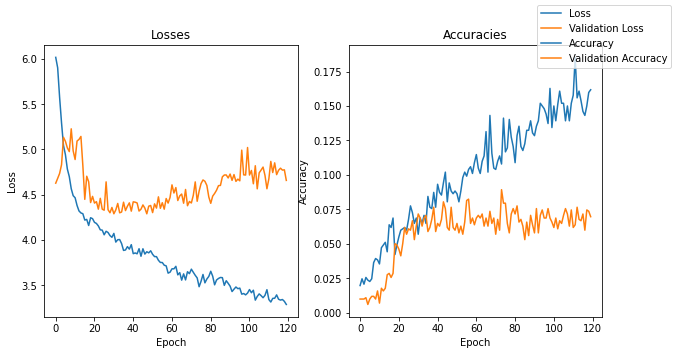

In [20]:
history = {'loss': [6.015894, 5.900825, 5.575938, 5.292697, 5.044319, 4.942483, 4.783807, 4.700113, 4.566978, 4.490133, 4.467162, 4.382183, 4.321878, 4.299568, 4.29094, 4.220905, 4.228153, 4.161135, 4.246659, 4.236358, 4.195755, 4.183529, 4.15624, 4.113066, 4.110096, 4.058498, 4.097252, 4.083723, 4.049861, 4.030771, 4.073817, 3.978166, 4.004461, 4.005783, 3.961231, 3.886083, 3.890865, 3.927771, 3.900445, 3.949588, 3.850421, 3.858187, 3.848899, 3.904911, 3.821562, 3.904393, 3.845587, 3.871548, 3.85919, 3.882108, 3.842995, 3.817919, 3.817778, 3.777169, 3.753211, 3.752674, 3.722704, 3.716101, 3.635473, 3.646072, 3.683441, 3.682965, 3.710595, 3.616582, 3.640886, 3.558267, 3.627316, 3.560688, 3.651298, 3.62972, 3.67934, 3.644833, 3.611681, 3.582685, 3.485706, 3.545867, 3.620921, 3.528394, 3.570902, 3.599214, 3.656217, 3.60212, 3.506569, 3.559863, 3.576679, 3.587711, 3.585622, 3.500665, 3.551907, 3.522945, 3.49165, 3.432332, 3.458516, 3.482734, 3.464061, 3.470294, 3.40362, 3.410676, 3.395911, 3.415549, 3.454465, 3.419413, 3.446895, 3.337657, 3.37804, 3.406459, 3.387028, 3.364351, 3.390811, 3.452921, 3.344301, 3.316866, 3.357511, 3.358222, 3.395463, 3.347714, 3.33819, 3.34476, 3.324317, 3.290164], 'accuracy': [0.019608, 0.02451, 0.020588, 0.02549, 0.023529, 0.022549, 0.02451, 0.036275, 0.039216, 0.038235, 0.035294, 0.047059, 0.04902, 0.05098, 0.044118, 0.063725, 0.061765, 0.068627, 0.042157, 0.04902, 0.054902, 0.059804, 0.060784, 0.061765, 0.059804, 0.067647, 0.077451, 0.072549, 0.064706, 0.068627, 0.056863, 0.068627, 0.064706, 0.070588, 0.064706, 0.084314, 0.076471, 0.07549, 0.087255, 0.076471, 0.093137, 0.087255, 0.085294, 0.094118, 0.101961, 0.080392, 0.094118, 0.088235, 0.086275, 0.088235, 0.086275, 0.080392, 0.088235, 0.098039, 0.101961, 0.09902, 0.103922, 0.105882, 0.10098, 0.108824, 0.114706, 0.104902, 0.10098, 0.109804, 0.113725, 0.131373, 0.101961, 0.143137, 0.115686, 0.104902, 0.103922, 0.109804, 0.113725, 0.107843, 0.141176, 0.116667, 0.119608, 0.140196, 0.127451, 0.120588, 0.108824, 0.128431, 0.135294, 0.120588, 0.117647, 0.122549, 0.132353, 0.132353, 0.139216, 0.130392, 0.128431, 0.135294, 0.139216, 0.151961, 0.15, 0.148039, 0.144118, 0.137255, 0.162745, 0.134314, 0.15, 0.139216, 0.15098, 0.160784, 0.151961, 0.151961, 0.139216, 0.15, 0.139216, 0.151961, 0.157843, 0.185294, 0.155882, 0.160784, 0.153922, 0.146078, 0.143137, 0.15, 0.159804, 0.161765], 'val_loss': [4.627974, 4.680903, 4.735023, 4.831739, 5.134456, 5.089382, 5.017103, 4.976289, 5.227515, 4.984959, 4.889005, 5.0928, 5.110307, 5.143511, 4.821533, 4.449454, 4.704485, 4.643034, 4.414062, 4.482258, 4.408204, 4.424108, 4.341455, 4.460896, 4.341353, 4.329812, 4.642344, 4.335189, 4.301862, 4.360102, 4.290412, 4.332961, 4.404238, 4.301114, 4.309831, 4.418189, 4.325501, 4.373901, 4.410888, 4.319384, 4.42214, 4.418212, 4.409889, 4.320298, 4.341056, 4.387923, 4.352644, 4.289942, 4.374397, 4.381658, 4.303286, 4.399817, 4.353086, 4.47717, 4.350617, 4.412477, 4.341023, 4.458548, 4.408125, 4.470556, 4.609345, 4.519488, 4.579195, 4.436503, 4.487694, 4.508008, 4.406933, 4.558453, 4.379143, 4.425945, 4.409428, 4.494512, 4.641959, 4.428424, 4.540409, 4.623711, 4.663584, 4.648619, 4.603005, 4.475445, 4.405708, 4.484723, 4.514583, 4.550246, 4.600704, 4.603069, 4.697789, 4.718046, 4.718679, 4.685128, 4.728647, 4.658999, 4.722695, 4.647643, 4.672843, 4.654042, 4.992322, 4.719851, 4.717705, 5.021373, 4.717676, 4.768123, 4.621274, 4.820329, 4.565541, 4.741817, 4.773018, 4.805477, 4.713447, 4.56618, 4.676413, 4.868036, 4.74528, 4.852143, 4.722189, 4.770218, 4.793365, 4.772024, 4.775234, 4.658586], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.010784, 0.005882, 0.009804, 0.011765, 0.011765, 0.009804, 0.015686, 0.006863, 0.017647, 0.015686, 0.017647, 0.027451, 0.028431, 0.02549, 0.028431, 0.05, 0.04902, 0.046078, 0.041176, 0.05, 0.061765, 0.056863, 0.060784, 0.059804, 0.066667, 0.052941, 0.062745, 0.071569, 0.068627, 0.062745, 0.068627, 0.070588, 0.058824, 0.061765, 0.067647, 0.076471, 0.058824, 0.064706, 0.062745, 0.067647, 0.080392, 0.07549, 0.061765, 0.059804, 0.076471, 0.061765, 0.059804, 0.064706, 0.057843, 0.062745, 0.056863, 0.065686, 0.081373, 0.082353, 0.064706, 0.068627, 0.063725, 0.068627, 0.070588, 0.068627, 0.071569, 0.062745, 0.068627, 0.062745, 0.073529, 0.064706, 0.068627, 0.056863, 0.067647, 0.059804, 0.089216, 0.079412, 0.079412, 0.064706, 0.057843, 0.071569, 0.07549, 0.071569, 0.077451, 0.065686, 0.067647, 0.062745, 0.052941, 0.065686, 0.055882, 0.070588, 0.063725, 0.057843, 0.07549, 0.057843, 0.070588, 0.07451, 0.068627, 0.068627, 0.07549, 0.068627, 0.065686, 0.061765, 0.068627, 0.060784, 0.066667, 0.064706, 0.070588, 0.07549, 0.071569, 0.062745, 0.07451, 0.061765, 0.063725, 0.076471, 0.067647, 0.066667, 0.071569, 0.059804, 0.07451, 0.073529, 0.069608]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 13 (depth=30, skips=[2, 3, 5, 8, 13])

0.131373 | 0.098039


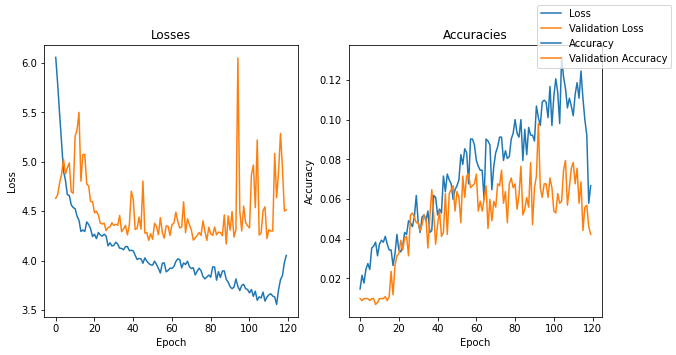

In [21]:
history = {'loss': [6.054215, 5.785926, 5.482844, 5.196342, 4.903621, 4.814833, 4.665305, 4.657789, 4.563179, 4.535764, 4.524893, 4.448732, 4.407328, 4.293612, 4.308867, 4.293216, 4.390233, 4.363356, 4.321597, 4.242415, 4.266517, 4.221354, 4.283732, 4.258945, 4.24683, 4.266548, 4.247328, 4.148732, 4.179712, 4.146996, 4.153595, 4.185728, 4.165442, 4.124728, 4.122862, 4.109126, 4.140209, 4.14167, 4.099525, 4.104393, 4.097873, 4.053221, 4.010542, 4.021713, 4.016195, 3.973129, 4.026817, 3.994184, 3.970705, 3.956261, 3.953622, 3.993676, 3.960386, 3.920689, 3.874067, 3.972203, 3.976675, 3.885864, 3.899912, 3.923632, 3.920359, 3.939577, 3.990419, 4.016676, 4.009859, 3.925329, 3.976515, 3.959809, 3.993507, 3.937474, 3.919184, 3.927308, 3.854149, 3.891754, 3.922504, 3.897025, 3.837827, 3.814434, 3.833303, 3.852973, 3.831594, 3.936492, 3.934212, 3.801324, 3.886952, 3.829486, 3.894344, 3.895128, 3.809984, 3.781684, 3.735099, 3.715419, 3.730964, 3.813891, 3.737773, 3.696958, 3.747626, 3.759792, 3.715926, 3.707093, 3.672711, 3.706959, 3.638744, 3.690042, 3.598272, 3.632962, 3.621426, 3.6814, 3.58976, 3.629637, 3.653083, 3.663971, 3.64043, 3.63203, 3.556142, 3.70465, 3.806488, 3.84698, 3.979234, 4.051758], 'accuracy': [0.014706, 0.021569, 0.017647, 0.02451, 0.027451, 0.02451, 0.035294, 0.036275, 0.038235, 0.031373, 0.037255, 0.039216, 0.038235, 0.041176, 0.037255, 0.034314, 0.034314, 0.026471, 0.032353, 0.042157, 0.034314, 0.033333, 0.036275, 0.043137, 0.042157, 0.04902, 0.048039, 0.046078, 0.05098, 0.061765, 0.048039, 0.043137, 0.05098, 0.051961, 0.04902, 0.053922, 0.043137, 0.044118, 0.061765, 0.060784, 0.051961, 0.054902, 0.052941, 0.071569, 0.063725, 0.072549, 0.069608, 0.067647, 0.059804, 0.064706, 0.066667, 0.069608, 0.082353, 0.077451, 0.085294, 0.083333, 0.067647, 0.090196, 0.090196, 0.087255, 0.079412, 0.076471, 0.07451, 0.07451, 0.059804, 0.090196, 0.089216, 0.087255, 0.064706, 0.076471, 0.083333, 0.086275, 0.091176, 0.091176, 0.079412, 0.084314, 0.080392, 0.081373, 0.090196, 0.093137, 0.1, 0.093137, 0.091176, 0.1, 0.079412, 0.095098, 0.082353, 0.096078, 0.092157, 0.092157, 0.089216, 0.106863, 0.10098, 0.097059, 0.108824, 0.109804, 0.108824, 0.10098, 0.116667, 0.097059, 0.111765, 0.120588, 0.113725, 0.098039, 0.131373, 0.121569, 0.115686, 0.105882, 0.110784, 0.106863, 0.101961, 0.112745, 0.118627, 0.110784, 0.12451, 0.110784, 0.1, 0.092157, 0.057843, 0.066667], 'val_loss': [4.6291, 4.666695, 4.785149, 4.873291, 5.026415, 4.875466, 4.937228, 4.986723, 4.695001, 4.680115, 5.256859, 5.320936, 5.498356, 4.80193, 5.070002, 5.074072, 4.773203, 4.754928, 4.595882, 4.595111, 4.48279, 4.498529, 4.45898, 4.377513, 4.369937, 4.377309, 4.302323, 4.333803, 4.34011, 4.381389, 4.354999, 4.367118, 4.35654, 4.456041, 4.291284, 4.3181, 4.356291, 4.259381, 4.363782, 4.700639, 4.617132, 4.314528, 4.325209, 4.440257, 4.317918, 4.804203, 4.276947, 4.283072, 4.204214, 4.272045, 4.215316, 4.376519, 4.345206, 4.260873, 4.433187, 4.285724, 4.226414, 4.350721, 4.345616, 4.254079, 4.361404, 4.380233, 4.488991, 4.394555, 4.329936, 4.339065, 4.594329, 4.281428, 4.42184, 4.360566, 4.308719, 4.206115, 4.229719, 4.253768, 4.283306, 4.255054, 4.401086, 4.295702, 4.203907, 4.335894, 4.270896, 4.254085, 4.3384, 4.260756, 4.287182, 4.283509, 4.251901, 4.461349, 4.167988, 4.451089, 4.307246, 4.495557, 4.237618, 4.310531, 6.048751, 4.498125, 4.29945, 4.549633, 4.383325, 4.352137, 4.329022, 4.867774, 4.966162, 4.534436, 5.219469, 4.258421, 4.277653, 4.506125, 4.543108, 4.222507, 4.311616, 4.298402, 4.298363, 5.083171, 4.635273, 4.897256, 5.28371, 4.941187, 4.500695, 4.513122], 'val_accuracy': [0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.006863, 0.007843, 0.009804, 0.009804, 0.009804, 0.010784, 0.008824, 0.010784, 0.023529, 0.011765, 0.026471, 0.031373, 0.032353, 0.039216, 0.034314, 0.040196, 0.041176, 0.031373, 0.051961, 0.052941, 0.05098, 0.048039, 0.048039, 0.044118, 0.047059, 0.051961, 0.05, 0.035294, 0.05098, 0.064706, 0.051961, 0.037255, 0.047059, 0.053922, 0.041176, 0.043137, 0.062745, 0.042157, 0.062745, 0.064706, 0.066667, 0.053922, 0.063725, 0.060784, 0.048039, 0.071569, 0.060784, 0.071569, 0.072549, 0.065686, 0.066667, 0.067647, 0.072549, 0.053922, 0.058824, 0.053922, 0.059804, 0.066667, 0.045098, 0.059804, 0.04902, 0.058824, 0.055882, 0.067647, 0.066667, 0.07451, 0.057843, 0.063725, 0.048039, 0.067647, 0.070588, 0.065686, 0.067647, 0.054902, 0.061765, 0.076471, 0.051961, 0.054902, 0.060784, 0.055882, 0.078431, 0.047059, 0.065686, 0.071569, 0.098039, 0.065686, 0.060784, 0.067647, 0.067647, 0.060784, 0.070588, 0.065686, 0.053922, 0.052941, 0.062745, 0.057843, 0.058824, 0.07451, 0.079412, 0.056863, 0.065686, 0.07549, 0.078431, 0.067647, 0.07549, 0.057843, 0.068627, 0.044118, 0.055882, 0.056863, 0.046078, 0.042157]}
plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 15
* depth=30, skips=[2, 3, 5, 8, 13, 21], skip_start_depth=10
* heat=1, chill=3, reheat=0, min_channels=32, max_channels=256

0.244118 | 0.106863


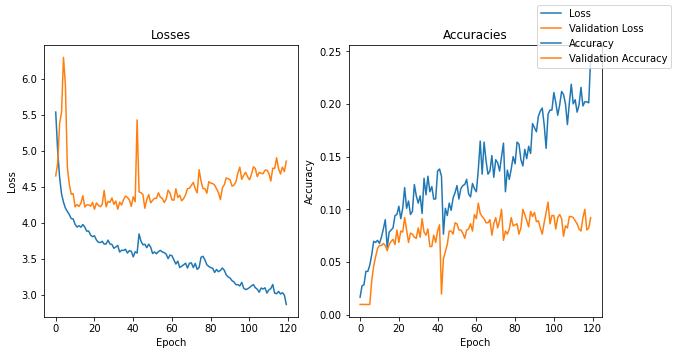

In [5]:
history = {'loss': [5.536274, 4.993477, 4.632351, 4.400572, 4.284237, 4.202638, 4.155856, 4.11271, 4.056193, 4.051891, 3.975818, 3.9389, 3.957584, 3.937419, 3.974126, 3.938051, 3.881925, 3.883922, 3.826439, 3.805271, 3.816988, 3.759807, 3.727982, 3.72317, 3.741451, 3.702019, 3.703482, 3.75725, 3.703315, 3.697093, 3.643899, 3.663211, 3.682113, 3.591743, 3.616124, 3.615262, 3.630246, 3.577754, 3.611365, 3.601992, 3.52517, 3.595528, 3.577371, 3.843477, 3.742067, 3.6928, 3.699981, 3.651918, 3.70134, 3.659356, 3.571108, 3.593341, 3.568048, 3.598187, 3.614367, 3.591824, 3.584394, 3.562167, 3.500552, 3.551227, 3.539699, 3.481599, 3.424394, 3.465747, 3.377347, 3.39496, 3.414252, 3.437029, 3.369815, 3.436349, 3.441375, 3.376668, 3.433643, 3.350498, 3.376273, 3.519964, 3.532763, 3.482932, 3.414901, 3.391872, 3.374984, 3.366931, 3.30829, 3.349404, 3.318717, 3.33672, 3.370087, 3.337354, 3.275119, 3.245677, 3.229227, 3.193479, 3.175446, 3.138577, 3.1386, 3.120887, 3.170035, 3.090143, 3.070039, 3.080594, 3.098392, 3.120902, 3.139442, 3.097104, 3.075296, 3.033009, 3.091186, 3.077903, 3.094802, 3.021253, 3.066143, 3.083349, 3.140977, 3.019323, 3.01302, 3.044597, 3.008937, 3.026612, 2.994068, 2.863598], 'accuracy': [0.016667, 0.027451, 0.028431, 0.041176, 0.041176, 0.047059, 0.056863, 0.069608, 0.068627, 0.070588, 0.067647, 0.073529, 0.081373, 0.090196, 0.063725, 0.078431, 0.080392, 0.082353, 0.094118, 0.095098, 0.102941, 0.091176, 0.10098, 0.120588, 0.10098, 0.107843, 0.095098, 0.098039, 0.123529, 0.112745, 0.105882, 0.112745, 0.096078, 0.129412, 0.113725, 0.131373, 0.116667, 0.121569, 0.109804, 0.109804, 0.136275, 0.138235, 0.131373, 0.076471, 0.10098, 0.094118, 0.105882, 0.09902, 0.110784, 0.115686, 0.122549, 0.109804, 0.119608, 0.122549, 0.123529, 0.128431, 0.114706, 0.111765, 0.12451, 0.119608, 0.116667, 0.137255, 0.164706, 0.133333, 0.163725, 0.146078, 0.133333, 0.136275, 0.15098, 0.130392, 0.147059, 0.144118, 0.136275, 0.15, 0.162745, 0.116667, 0.137255, 0.128431, 0.138235, 0.15, 0.143137, 0.163725, 0.161765, 0.147059, 0.141176, 0.156863, 0.148039, 0.159804, 0.152941, 0.181373, 0.177451, 0.173529, 0.188235, 0.193137, 0.196078, 0.180392, 0.157843, 0.190196, 0.194118, 0.194118, 0.210784, 0.20098, 0.189216, 0.19902, 0.211765, 0.208824, 0.2, 0.180392, 0.20098, 0.218627, 0.2, 0.203922, 0.192157, 0.19902, 0.215686, 0.198039, 0.201961, 0.201961, 0.20098, 0.244118], 'val_loss': [4.650072, 4.825594, 5.38053, 5.530797, 6.296842, 5.908079, 4.766269, 4.534273, 4.395364, 4.403523, 4.219553, 4.250991, 4.225577, 4.269758, 4.373871, 4.218633, 4.247396, 4.246975, 4.228945, 4.280674, 4.18603, 4.274776, 4.241843, 4.220643, 4.255244, 4.447372, 4.219778, 4.295826, 4.281943, 4.343822, 4.254745, 4.300503, 4.187218, 4.284276, 4.24587, 4.320876, 4.369665, 4.350195, 4.317116, 4.226509, 4.360094, 4.290666, 5.427366, 4.427502, 4.417524, 4.390625, 4.200261, 4.322777, 4.390047, 4.275359, 4.310504, 4.337167, 4.338964, 4.415094, 4.352321, 4.336462, 4.280568, 4.326277, 4.45149, 4.410202, 4.316596, 4.312085, 4.470498, 4.349976, 4.381222, 4.30409, 4.334014, 4.386824, 4.472154, 4.47881, 4.51754, 4.559649, 4.471919, 4.413827, 4.735658, 4.579099, 4.472845, 4.472551, 4.409549, 4.569163, 4.549353, 4.54307, 4.522135, 4.469812, 4.416013, 4.320113, 4.484236, 4.528025, 4.621921, 4.610322, 4.594408, 4.507814, 4.522683, 4.565703, 4.689722, 4.770717, 4.602601, 4.659383, 4.699421, 4.637835, 4.596123, 4.670212, 4.776459, 4.752884, 4.640412, 4.697469, 4.68671, 4.679582, 4.729327, 4.729766, 4.684772, 4.578316, 4.755779, 4.753884, 4.901177, 4.747099, 4.676806, 4.771779, 4.709968, 4.85527], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.032353, 0.046078, 0.054902, 0.062745, 0.065686, 0.065686, 0.067647, 0.065686, 0.060784, 0.066667, 0.069608, 0.071569, 0.066667, 0.080392, 0.068627, 0.079412, 0.078431, 0.092157, 0.080392, 0.068627, 0.077451, 0.076471, 0.073529, 0.072549, 0.082353, 0.073529, 0.091176, 0.078431, 0.07549, 0.081373, 0.064706, 0.064706, 0.07549, 0.068627, 0.079412, 0.085294, 0.019608, 0.052941, 0.059804, 0.066667, 0.079412, 0.079412, 0.076471, 0.087255, 0.086275, 0.080392, 0.080392, 0.077451, 0.072549, 0.080392, 0.081373, 0.086275, 0.079412, 0.095098, 0.091176, 0.105882, 0.096078, 0.093137, 0.091176, 0.087255, 0.087255, 0.090196, 0.07549, 0.086275, 0.092157, 0.082353, 0.089216, 0.1, 0.070588, 0.079412, 0.076471, 0.081373, 0.092157, 0.084314, 0.085294, 0.086275, 0.076471, 0.082353, 0.1, 0.095098, 0.089216, 0.083333, 0.098039, 0.093137, 0.097059, 0.088235, 0.089216, 0.082353, 0.076471, 0.087255, 0.097059, 0.106863, 0.086275, 0.094118, 0.094118, 0.081373, 0.092157, 0.095098, 0.091176, 0.07451, 0.084314, 0.082353, 0.093137, 0.093137, 0.092157, 0.089216, 0.086275, 0.081373, 0.079412, 0.092157, 0.1, 0.080392, 0.082353, 0.092157]}

run_summary(history)

## Model 16
* depth=30, skips=[5, 8, 13, 21], skip_start_depth=10
* heat=1, chill=3, reheat=0, min_channels=32, max_channels=256

0.012745 | 0.010784


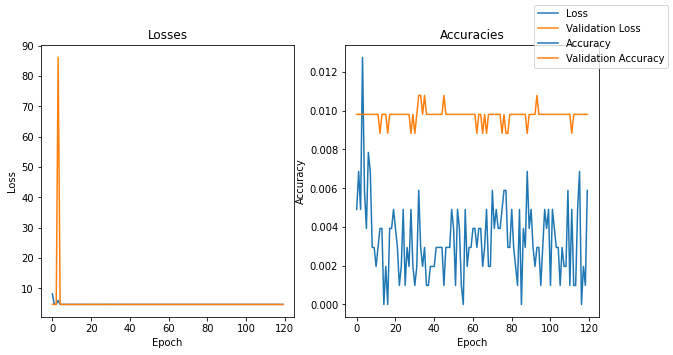

In [6]:
history = {'loss': [8.107353, 4.668014, 4.636436, 5.948383, 4.648056, 4.637525, 4.635263, 4.635285, 4.635172, 4.635009, 4.63535, 4.635157, 4.635493, 4.63595, 4.635153, 4.63538, 4.63552, 4.635382, 4.635445, 4.635191, 4.635669, 4.635463, 4.635111, 4.635412, 4.635711, 4.635271, 4.63484, 4.635444, 4.63556, 4.662135, 4.639126, 4.63572, 4.634955, 4.635171, 4.635461, 4.635015, 4.635457, 4.644987, 4.635242, 4.635611, 4.634885, 4.634888, 4.635121, 4.635246, 4.635407, 4.635383, 4.635422, 4.634939, 4.635337, 4.635571, 4.635543, 4.634747, 4.635523, 4.635196, 4.634825, 4.635035, 4.635637, 4.635323, 4.634748, 4.6356, 4.634761, 4.63524, 4.634982, 4.634934, 4.634642, 4.634482, 4.634912, 4.63518, 4.634826, 4.636244, 4.635141, 4.635348, 4.635082, 4.634567, 4.635418, 4.634493, 4.634676, 4.635731, 4.635341, 4.635173, 4.635612, 4.634902, 4.634915, 4.634991, 4.634633, 4.634897, 4.634834, 4.635208, 4.634656, 4.635061, 4.634756, 4.634879, 4.635653, 4.63486, 4.634687, 4.634566, 4.634543, 4.635149, 4.634795, 4.63483, 4.6353, 4.635151, 4.635016, 4.634186, 4.634668, 4.634679, 4.635074, 4.634875, 4.635229, 4.634905, 4.635102, 4.63485, 4.634492, 4.635016, 4.635433, 4.635683, 4.634511, 4.634597, 4.634397, 4.634914], 'accuracy': [0.004902, 0.006863, 0.004902, 0.012745, 0.005882, 0.003922, 0.007843, 0.006863, 0.002941, 0.002941, 0.001961, 0.002941, 0.003922, 0.003922, 0.0, 0.001961, 0.0, 0.003922, 0.003922, 0.004902, 0.003922, 0.002941, 0.00098, 0.001961, 0.004902, 0.00098, 0.002941, 0.001961, 0.004902, 0.001961, 0.00098, 0.001961, 0.005882, 0.002941, 0.001961, 0.002941, 0.00098, 0.00098, 0.001961, 0.001961, 0.001961, 0.002941, 0.002941, 0.002941, 0.002941, 0.00098, 0.002941, 0.002941, 0.002941, 0.004902, 0.003922, 0.00098, 0.004902, 0.003922, 0.00098, 0.0, 0.004902, 0.001961, 0.002941, 0.002941, 0.003922, 0.003922, 0.002941, 0.003922, 0.003922, 0.001961, 0.002941, 0.004902, 0.001961, 0.001961, 0.005882, 0.003922, 0.004902, 0.003922, 0.003922, 0.004902, 0.005882, 0.005882, 0.002941, 0.002941, 0.004902, 0.002941, 0.001961, 0.00098, 0.004902, 0.0, 0.003922, 0.002941, 0.006863, 0.003922, 0.004902, 0.002941, 0.001961, 0.002941, 0.002941, 0.00098, 0.002941, 0.004902, 0.003922, 0.004902, 0.00098, 0.004902, 0.003922, 0.002941, 0.002941, 0.00098, 0.002941, 0.001961, 0.001961, 0.005882, 0.00098, 0.004902, 0.00098, 0.00098, 0.004902, 0.006863, 0.0, 0.001961, 0.00098, 0.005882], 'val_loss': [4.683701, 4.625417, 4.625637, 86.119202, 4.810477, 4.625421, 4.62525, 4.625169, 4.625104, 4.625074, 4.62506, 4.625196, 4.625519, 4.626249, 4.625543, 4.626193, 4.626847, 4.626854, 4.628443, 4.629088, 4.628376, 4.630496, 4.625541, 4.628336, 4.626603, 4.627239, 4.626796, 4.630466, 4.629552, 4.636973, 4.626369, 4.625711, 4.625745, 4.625904, 4.628053, 4.628758, 4.627579, 4.624857, 4.624474, 4.62473, 4.624936, 4.62464, 4.624506, 4.624411, 4.624447, 4.624565, 4.62454, 4.624743, 4.624432, 4.624568, 4.624558, 4.624722, 4.624599, 4.624704, 4.624696, 4.624705, 4.624606, 4.624619, 4.624743, 4.62465, 4.624727, 4.624767, 4.62464, 4.624804, 4.624831, 4.624865, 4.624623, 4.624791, 4.624836, 4.624577, 4.62452, 4.624581, 4.624507, 4.624561, 4.6245, 4.624509, 4.62447, 4.624697, 4.625032, 4.624625, 4.624637, 4.624745, 4.624671, 4.624796, 4.624774, 4.624524, 4.624709, 4.624583, 4.624555, 4.624587, 4.624595, 4.624517, 4.62473, 4.624625, 4.624913, 4.624724, 4.624684, 4.62438, 4.624468, 4.624297, 4.624348, 4.624453, 4.624315, 4.624654, 4.6246, 4.624747, 4.62476, 4.624676, 4.624675, 4.624607, 4.624701, 4.624714, 4.624747, 4.624928, 4.624818, 4.624776, 4.624717, 4.624994, 4.625103, 4.624768], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.008824, 0.009804, 0.010784, 0.010784, 0.009804, 0.010784, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.008824, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.008824, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804]}

run_summary(history)

## Model 17
* depth=30, skips=[], skip_start_depth=10, **kwargs
* heat=1, chill=3, reheat=0, min_channels=32, max_channels=256

0.955882 | 0.142157


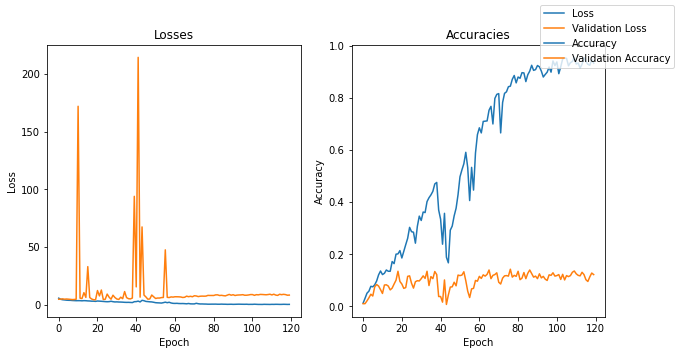

In [7]:
history = {'loss': [5.592106, 4.612902, 4.245629, 4.06916, 3.856554, 3.759481, 3.722899, 3.574567, 3.48276, 3.411261, 3.436161, 3.436061, 3.29543, 3.456244, 3.379206, 3.222725, 3.154624, 2.991542, 2.982483, 2.82044, 3.128771, 3.029031, 2.901202, 2.763915, 2.612958, 2.514657, 2.594712, 2.919304, 2.547246, 2.317412, 2.387638, 2.260883, 2.216465, 2.133602, 2.003903, 1.944303, 1.983049, 1.885635, 1.77446, 2.536668, 2.612296, 3.047676, 2.335273, 3.746856, 3.386025, 2.780627, 2.628834, 2.436891, 2.338678, 2.040129, 1.677808, 1.565296, 1.483537, 1.350093, 1.704273, 2.138779, 1.676432, 2.048523, 1.423669, 1.110796, 1.045256, 1.121861, 0.954032, 0.909774, 0.946325, 0.849194, 0.715212, 0.980918, 0.669546, 0.628935, 0.629466, 1.146807, 0.771122, 0.568736, 0.585025, 0.506885, 0.481744, 0.374422, 0.377425, 0.418483, 0.411067, 0.434504, 0.342491, 0.340964, 0.434478, 0.35058, 0.34071, 0.250875, 0.29069, 0.337342, 0.239547, 0.285361, 0.339848, 0.383174, 0.337414, 0.308875, 0.293171, 0.341626, 0.196426, 0.249877, 0.23378, 0.357634, 0.267125, 0.173068, 0.181366, 0.153944, 0.270974, 0.222735, 0.194589, 0.15399, 0.241931, 0.209706, 0.280175, 0.255386, 0.193086, 0.209364, 0.293138, 0.251459, 0.182298, 0.211749], 'accuracy': [0.011765, 0.030392, 0.05, 0.057843, 0.076471, 0.07451, 0.082353, 0.097059, 0.120588, 0.135294, 0.121569, 0.126471, 0.139216, 0.134314, 0.134314, 0.171569, 0.163725, 0.2, 0.20098, 0.213725, 0.185294, 0.210784, 0.236275, 0.260784, 0.302941, 0.286275, 0.284314, 0.242157, 0.306863, 0.346078, 0.329412, 0.361765, 0.359804, 0.401961, 0.416667, 0.427451, 0.441176, 0.469608, 0.47549, 0.369608, 0.334314, 0.238235, 0.356863, 0.188235, 0.166667, 0.292157, 0.307843, 0.347059, 0.376471, 0.428431, 0.497059, 0.523529, 0.547059, 0.591176, 0.532353, 0.405882, 0.533333, 0.446078, 0.588235, 0.658824, 0.685294, 0.665686, 0.709804, 0.710784, 0.711765, 0.752941, 0.767647, 0.7, 0.798039, 0.813725, 0.816667, 0.665686, 0.782353, 0.817647, 0.823529, 0.843137, 0.845098, 0.871569, 0.886275, 0.857843, 0.880392, 0.87549, 0.897059, 0.896078, 0.862745, 0.889216, 0.902941, 0.92549, 0.905882, 0.908824, 0.92451, 0.919608, 0.902941, 0.880392, 0.890196, 0.89902, 0.918627, 0.89902, 0.942157, 0.92451, 0.938235, 0.893137, 0.919608, 0.95, 0.953922, 0.951961, 0.923529, 0.935294, 0.940196, 0.955882, 0.930392, 0.934314, 0.914706, 0.929412, 0.954902, 0.940196, 0.929412, 0.92549, 0.948039, 0.933333], 'val_loss': [4.658133, 4.739519, 5.006958, 4.696227, 4.865866, 4.723618, 4.557548, 4.390136, 4.459458, 4.682786, 172.02124, 5.611772, 5.257137, 10.381396, 6.259373, 32.954273, 6.179713, 4.851186, 4.265794, 4.191954, 12.218324, 7.546309, 12.663316, 4.43459, 4.64685, 9.124617, 6.451657, 4.696491, 8.173133, 6.153766, 4.876655, 4.499529, 6.446455, 5.149163, 11.323174, 6.093146, 5.148079, 4.958189, 5.712851, 93.914581, 15.381338, 214.449066, 6.470473, 67.390175, 8.284958, 6.641525, 4.705769, 4.910334, 8.316898, 6.787944, 5.316938, 5.720865, 5.695783, 6.095757, 6.199803, 47.502476, 6.321078, 6.14014, 6.695528, 6.511611, 6.823812, 6.815316, 6.759239, 6.626575, 6.198578, 6.38989, 7.346974, 6.869823, 7.223507, 6.832352, 7.682318, 7.509385, 6.963733, 7.282256, 7.380098, 7.316401, 7.388378, 8.009515, 7.936806, 7.935128, 7.927566, 8.460303, 8.478038, 7.900926, 8.075174, 7.784445, 7.583346, 8.23074, 8.855562, 8.162069, 8.587874, 7.918191, 8.257031, 8.374498, 8.423062, 8.621605, 8.133873, 8.169545, 8.387053, 8.720013, 8.71155, 8.050611, 8.643885, 8.468121, 8.847361, 8.785559, 8.657656, 8.544936, 8.726389, 9.010827, 8.416876, 9.027211, 8.279429, 8.003911, 8.994015, 8.625094, 8.929731, 8.707896, 8.163895, 8.257979], 'val_accuracy': [0.009804, 0.009804, 0.020588, 0.032353, 0.046078, 0.039216, 0.07451, 0.083333, 0.077451, 0.063725, 0.04902, 0.081373, 0.082353, 0.077451, 0.062745, 0.069608, 0.085294, 0.1, 0.134314, 0.095098, 0.085294, 0.068627, 0.071569, 0.114706, 0.116667, 0.088235, 0.069608, 0.094118, 0.098039, 0.097059, 0.105882, 0.116667, 0.106863, 0.134314, 0.079412, 0.113725, 0.105882, 0.133333, 0.121569, 0.037255, 0.037255, 0.015686, 0.10098, 0.006863, 0.043137, 0.073529, 0.07451, 0.092157, 0.078431, 0.119608, 0.117647, 0.119608, 0.132353, 0.098039, 0.057843, 0.033333, 0.066667, 0.068627, 0.09902, 0.096078, 0.114706, 0.106863, 0.120588, 0.115686, 0.122549, 0.139216, 0.105882, 0.118627, 0.121569, 0.128431, 0.092157, 0.085294, 0.107843, 0.116667, 0.117647, 0.115686, 0.142157, 0.111765, 0.118627, 0.114706, 0.134314, 0.101961, 0.107843, 0.129412, 0.105882, 0.126471, 0.139216, 0.12549, 0.111765, 0.115686, 0.105882, 0.12451, 0.108824, 0.114706, 0.103922, 0.09902, 0.120588, 0.118627, 0.128431, 0.115686, 0.117647, 0.121569, 0.102941, 0.122549, 0.10098, 0.117647, 0.113725, 0.117647, 0.130392, 0.135294, 0.12451, 0.118627, 0.116667, 0.130392, 0.121569, 0.101961, 0.095098, 0.112745, 0.127451, 0.121569]}

run_summary(history)

0.094118 | 0.019608


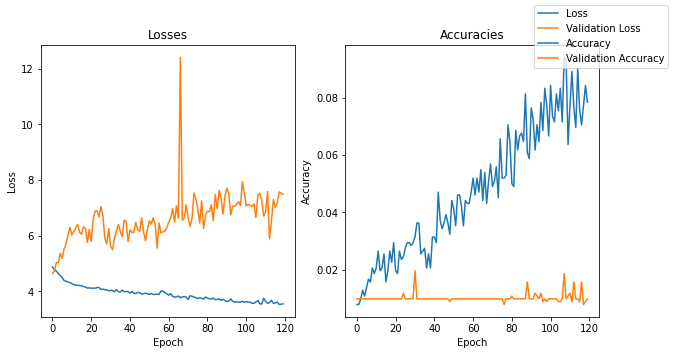

In [8]:
history = {'loss': [4.871417, 4.771596, 4.723434, 4.643519, 4.556887, 4.501026, 4.383354, 4.365506, 4.327738, 4.315321, 4.273868, 4.243465, 4.217766, 4.214127, 4.209206, 4.195657, 4.16769, 4.15327, 4.115177, 4.122167, 4.113773, 4.112818, 4.11344, 4.133971, 4.138291, 4.064088, 4.078293, 4.056037, 4.056769, 4.014827, 4.037381, 4.026498, 3.984112, 4.059134, 3.988096, 3.973626, 4.040638, 3.985075, 3.991102, 3.993538, 3.933818, 3.994849, 3.92111, 3.925516, 3.957804, 3.95215, 3.898625, 3.90997, 3.932093, 3.91096, 3.889164, 3.919622, 3.890255, 3.886805, 3.896146, 3.887223, 4.007841, 4.004412, 3.955366, 3.903688, 3.860383, 3.917065, 3.818202, 3.78963, 3.804612, 3.826782, 3.769608, 3.798153, 3.812695, 3.790601, 3.705191, 3.841148, 3.823512, 3.791054, 3.771092, 3.737417, 3.768944, 3.746271, 3.720238, 3.795049, 3.756722, 3.728386, 3.732321, 3.754666, 3.698235, 3.707903, 3.731474, 3.66897, 3.715488, 3.667234, 3.633199, 3.652515, 3.72405, 3.641031, 3.610712, 3.621687, 3.612502, 3.606526, 3.638023, 3.607559, 3.627126, 3.605467, 3.603972, 3.571634, 3.565548, 3.621187, 3.66445, 3.555748, 3.542195, 3.746808, 3.639762, 3.568217, 3.594761, 3.676035, 3.567914, 3.585137, 3.617995, 3.527932, 3.534631, 3.548791], 'accuracy': [0.007843, 0.007843, 0.009804, 0.012745, 0.010784, 0.013725, 0.016667, 0.015686, 0.020588, 0.018627, 0.020588, 0.026471, 0.019608, 0.020588, 0.02549, 0.015686, 0.019608, 0.026471, 0.022549, 0.029412, 0.019608, 0.018627, 0.026471, 0.023529, 0.02451, 0.027451, 0.029412, 0.029412, 0.028431, 0.029412, 0.031373, 0.036275, 0.036275, 0.02549, 0.026471, 0.027451, 0.020588, 0.02549, 0.020588, 0.031373, 0.031373, 0.029412, 0.047059, 0.037255, 0.034314, 0.036275, 0.039216, 0.036275, 0.032353, 0.044118, 0.041176, 0.035294, 0.046078, 0.046078, 0.042157, 0.035294, 0.044118, 0.043137, 0.043137, 0.047059, 0.051961, 0.046078, 0.051961, 0.047059, 0.054902, 0.044118, 0.053922, 0.043137, 0.05098, 0.056863, 0.04902, 0.05098, 0.055882, 0.045098, 0.065686, 0.051961, 0.051961, 0.052941, 0.070588, 0.064706, 0.05, 0.04902, 0.068627, 0.061765, 0.066667, 0.067647, 0.064706, 0.081373, 0.060784, 0.058824, 0.076471, 0.072549, 0.061765, 0.070588, 0.064706, 0.078431, 0.068627, 0.083333, 0.077451, 0.066667, 0.084314, 0.073529, 0.071569, 0.081373, 0.07549, 0.083333, 0.071569, 0.094118, 0.093137, 0.063725, 0.077451, 0.089216, 0.076471, 0.069608, 0.090196, 0.07549, 0.070588, 0.077451, 0.084314, 0.078431], 'val_loss': [4.635621, 4.730699, 5.02878, 5.032125, 5.360426, 5.185587, 5.527984, 5.695534, 6.017393, 6.293448, 6.035131, 6.140839, 6.276914, 6.40065, 6.120183, 6.049806, 6.317244, 6.252729, 5.757877, 6.225894, 5.788705, 6.59946, 6.878463, 6.88942, 6.670075, 7.042904, 6.725554, 5.909064, 5.700595, 6.250113, 5.614655, 5.494224, 5.916559, 6.154147, 6.401573, 6.14586, 5.965441, 6.549826, 6.511126, 5.785333, 6.199446, 6.118809, 6.109448, 6.479402, 6.20494, 6.154323, 6.639084, 6.13592, 5.816686, 6.228883, 6.525671, 6.411066, 6.644239, 6.421186, 5.551446, 6.455317, 6.093859, 6.139711, 6.166828, 6.282398, 6.485676, 6.613594, 6.968403, 6.490037, 7.066725, 6.620941, 12.401568, 6.553042, 6.625939, 7.104714, 6.63432, 6.33031, 6.614089, 7.530832, 7.330595, 6.955163, 6.453693, 7.246184, 6.254165, 6.742824, 6.878531, 6.85371, 7.111371, 6.529348, 7.471056, 6.960398, 7.628593, 7.338476, 6.775371, 7.418896, 7.700958, 7.483903, 6.743991, 7.06092, 7.059511, 7.114539, 7.217972, 7.081222, 7.935441, 7.537908, 7.068865, 7.124509, 7.095052, 7.051364, 7.132998, 6.647169, 7.448406, 7.509088, 7.258332, 6.701801, 6.858512, 7.583062, 5.887032, 6.515583, 7.299222, 7.011821, 7.173452, 7.573843, 7.524117, 7.480108], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.011765, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.019608, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.007843, 0.009804, 0.009804, 0.009804, 0.010784, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.015686, 0.009804, 0.009804, 0.009804, 0.011765, 0.010784, 0.009804, 0.011765, 0.008824, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.008824, 0.009804, 0.018627, 0.009804, 0.010784, 0.011765, 0.008824, 0.015686, 0.009804, 0.009804, 0.008824, 0.015686, 0.007843, 0.008824, 0.009804]}

run_summary(history)

## Model 21
* depth=4, skips=[], skip_start_depth=10
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.976471 | 0.32549


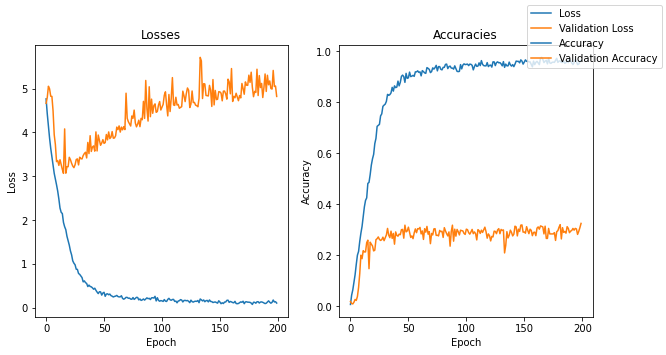

In [9]:
history = {'loss': [4.765802, 4.425703, 4.136488, 3.869751, 3.636682, 3.450625, 3.24889, 3.068028, 2.942689, 2.806835, 2.664817, 2.485176, 2.276671, 2.180214, 2.151277, 1.948001, 1.851021, 1.783639, 1.633613, 1.530584, 1.431531, 1.300159, 1.209825, 1.073298, 1.019184, 0.983737, 0.882912, 0.878259, 0.78546, 0.764336, 0.728639, 0.691595, 0.594122, 0.615887, 0.57711, 0.556973, 0.486386, 0.520386, 0.48891, 0.480769, 0.457463, 0.426442, 0.449361, 0.401239, 0.361126, 0.326616, 0.368456, 0.365593, 0.292365, 0.339688, 0.356215, 0.264637, 0.315745, 0.321781, 0.300284, 0.315303, 0.280299, 0.267556, 0.249258, 0.261966, 0.269154, 0.284833, 0.259246, 0.250976, 0.252988, 0.277313, 0.217005, 0.199029, 0.214687, 0.240948, 0.238871, 0.219542, 0.223493, 0.20119, 0.197697, 0.236162, 0.194564, 0.216122, 0.241711, 0.237827, 0.183108, 0.203843, 0.171632, 0.182967, 0.203835, 0.178708, 0.204619, 0.229021, 0.210884, 0.218332, 0.190559, 0.230033, 0.231718, 0.225167, 0.263713, 0.159381, 0.232042, 0.171743, 0.152496, 0.16701, 0.160849, 0.147555, 0.190097, 0.154614, 0.147723, 0.193908, 0.218524, 0.185011, 0.174022, 0.192041, 0.193577, 0.148992, 0.155588, 0.116513, 0.157096, 0.164184, 0.18883, 0.179649, 0.136311, 0.169123, 0.172259, 0.163274, 0.169735, 0.150301, 0.119925, 0.176939, 0.143816, 0.1321, 0.147719, 0.152881, 0.149211, 0.16966, 0.119905, 0.203835, 0.183754, 0.159781, 0.180658, 0.14149, 0.164321, 0.171031, 0.137759, 0.181314, 0.146709, 0.143602, 0.122733, 0.131349, 0.135551, 0.121046, 0.108965, 0.162342, 0.135062, 0.096468, 0.11642, 0.100729, 0.133115, 0.135303, 0.172515, 0.176191, 0.126684, 0.147547, 0.136697, 0.122292, 0.116739, 0.149753, 0.099556, 0.096067, 0.100973, 0.119076, 0.138347, 0.1281, 0.152304, 0.095773, 0.136672, 0.139712, 0.131009, 0.130907, 0.126247, 0.110722, 0.079135, 0.129106, 0.127414, 0.107225, 0.13951, 0.141106, 0.111584, 0.13363, 0.136819, 0.127692, 0.112355, 0.09886, 0.107485, 0.133406, 0.161163, 0.129845, 0.107649, 0.126415, 0.180177, 0.136445, 0.142075, 0.110853], 'accuracy': [0.007843, 0.044118, 0.064706, 0.096078, 0.12451, 0.164706, 0.20098, 0.215686, 0.254902, 0.287255, 0.313726, 0.351961, 0.390196, 0.415686, 0.42549, 0.482353, 0.486275, 0.516667, 0.553922, 0.578431, 0.596078, 0.638235, 0.658824, 0.705882, 0.709804, 0.713726, 0.747059, 0.754902, 0.784314, 0.789216, 0.793137, 0.803922, 0.831373, 0.827451, 0.830392, 0.837255, 0.858824, 0.844118, 0.864706, 0.857843, 0.859804, 0.883333, 0.864706, 0.878431, 0.901961, 0.906863, 0.90098, 0.878431, 0.913725, 0.894118, 0.896078, 0.918627, 0.90098, 0.902941, 0.905882, 0.901961, 0.919608, 0.919608, 0.923529, 0.917647, 0.919608, 0.903922, 0.92451, 0.920588, 0.915686, 0.913725, 0.936275, 0.933333, 0.929412, 0.916667, 0.920588, 0.935294, 0.930392, 0.936275, 0.945098, 0.923529, 0.940196, 0.940196, 0.929412, 0.927451, 0.937255, 0.937255, 0.94902, 0.95, 0.932353, 0.940196, 0.942157, 0.934314, 0.934314, 0.930392, 0.943137, 0.932353, 0.921569, 0.920588, 0.921569, 0.948039, 0.931373, 0.946078, 0.95098, 0.948039, 0.94902, 0.95, 0.944118, 0.95, 0.94902, 0.945098, 0.927451, 0.940196, 0.95, 0.941176, 0.942157, 0.954902, 0.944118, 0.963726, 0.94902, 0.944118, 0.943137, 0.943137, 0.955882, 0.940196, 0.945098, 0.946078, 0.938235, 0.958824, 0.958824, 0.944118, 0.955882, 0.958824, 0.954902, 0.955882, 0.95098, 0.943137, 0.959804, 0.937255, 0.95, 0.943137, 0.943137, 0.957843, 0.947059, 0.942157, 0.948039, 0.940196, 0.95, 0.961765, 0.960784, 0.960784, 0.954902, 0.966667, 0.961765, 0.95, 0.957843, 0.966667, 0.960784, 0.961765, 0.958824, 0.958824, 0.94902, 0.939216, 0.961765, 0.948039, 0.956863, 0.960784, 0.954902, 0.948039, 0.972549, 0.976471, 0.968627, 0.955882, 0.961765, 0.964706, 0.95098, 0.972549, 0.954902, 0.952941, 0.956863, 0.957843, 0.956863, 0.964706, 0.972549, 0.956863, 0.961765, 0.962745, 0.956863, 0.956863, 0.961765, 0.952941, 0.955882, 0.963726, 0.955882, 0.968627, 0.962745, 0.954902, 0.948039, 0.955882, 0.968627, 0.961765, 0.948039, 0.95, 0.959804, 0.964706], 'val_loss': [4.665627, 4.798496, 5.053766, 4.994207, 4.825804, 4.822445, 4.494781, 3.95056, 3.725579, 3.335633, 3.360046, 3.249899, 3.378824, 3.26611, 3.158168, 3.067511, 4.081254, 3.071954, 3.218579, 3.219889, 3.434288, 3.379752, 3.298071, 3.234799, 3.197475, 3.26453, 3.382403, 3.397817, 3.260718, 3.436249, 3.40278, 3.397059, 3.474327, 3.519817, 3.548851, 3.419486, 3.772789, 3.519089, 3.926754, 3.567187, 3.668505, 3.693625, 3.574338, 4.013466, 3.578656, 3.94171, 3.818941, 3.707945, 3.759488, 3.836362, 3.751241, 3.769942, 3.954074, 3.831346, 4.012273, 3.860865, 3.89338, 4.020297, 3.86963, 3.87449, 3.926366, 4.122601, 4.064499, 4.149813, 4.009151, 4.122061, 4.059978, 4.133406, 4.065438, 4.895527, 4.321489, 4.244752, 4.197627, 4.147363, 4.376058, 4.324495, 4.510107, 4.218232, 4.128907, 4.190202, 4.279868, 4.132854, 4.32134, 4.290672, 4.708981, 4.320719, 5.185891, 4.546227, 4.260256, 5.042241, 4.360182, 4.76002, 4.437458, 4.613796, 4.652633, 4.459613, 4.478216, 4.624685, 4.705202, 4.512159, 4.578448, 4.640225, 4.847307, 4.927193, 4.62622, 4.377595, 4.866454, 4.477175, 4.775986, 5.251085, 4.627407, 4.616735, 4.802859, 4.626177, 4.639294, 4.552019, 4.572721, 4.587058, 4.942373, 4.835895, 4.703976, 4.884261, 5.014503, 4.96358, 4.568636, 4.64912, 4.946054, 4.681896, 4.686574, 4.623598, 4.611346, 4.586891, 4.780919, 5.712831, 5.630751, 4.774338, 5.113525, 5.10364, 4.843925, 4.839741, 4.832702, 5.074032, 4.961746, 4.594114, 5.206496, 4.628717, 4.958242, 4.749491, 4.758027, 4.929844, 4.92554, 4.896495, 4.72165, 4.942184, 4.944532, 4.879723, 4.759696, 5.215583, 5.151818, 4.881415, 5.457418, 4.706909, 4.822213, 4.791773, 4.894245, 4.812821, 4.724705, 4.842482, 4.788858, 5.117124, 5.002311, 4.871784, 5.153256, 5.078046, 5.075184, 5.307124, 5.141577, 5.374331, 5.031478, 4.816, 4.937664, 4.911917, 5.442145, 4.843052, 5.296882, 5.024219, 5.118175, 4.797073, 5.026055, 5.333972, 4.935747, 5.304482, 5.087999, 5.174645, 5.002006, 4.989593, 5.414513, 5.048543, 5.058966, 4.822118], 'val_accuracy': [0.019608, 0.011765, 0.009804, 0.016667, 0.027451, 0.023529, 0.039216, 0.07451, 0.128431, 0.20098, 0.187255, 0.218627, 0.213725, 0.213725, 0.25, 0.259804, 0.148039, 0.251961, 0.244118, 0.237255, 0.217647, 0.220588, 0.261765, 0.265686, 0.272549, 0.262745, 0.258824, 0.261765, 0.271569, 0.257843, 0.269608, 0.280392, 0.305882, 0.279412, 0.269608, 0.295098, 0.266667, 0.286275, 0.244118, 0.292157, 0.278431, 0.27549, 0.283333, 0.281373, 0.30098, 0.301961, 0.267647, 0.318627, 0.292157, 0.296078, 0.310784, 0.291176, 0.270588, 0.276471, 0.265686, 0.288235, 0.303922, 0.289216, 0.304902, 0.303922, 0.309804, 0.284314, 0.296078, 0.262745, 0.304902, 0.291176, 0.313726, 0.283333, 0.293137, 0.246078, 0.286275, 0.280392, 0.303922, 0.304902, 0.278431, 0.279412, 0.276471, 0.298039, 0.293137, 0.295098, 0.270588, 0.308824, 0.296078, 0.285294, 0.276471, 0.292157, 0.236275, 0.294118, 0.318627, 0.255882, 0.302941, 0.27549, 0.301961, 0.293137, 0.280392, 0.29902, 0.297059, 0.296078, 0.286275, 0.282353, 0.302941, 0.30098, 0.289216, 0.283333, 0.292157, 0.301961, 0.285294, 0.292157, 0.285294, 0.260784, 0.30098, 0.297059, 0.286275, 0.29902, 0.290196, 0.30098, 0.310784, 0.293137, 0.267647, 0.284314, 0.277451, 0.256863, 0.27451, 0.272549, 0.295098, 0.294118, 0.285294, 0.3, 0.304902, 0.285294, 0.301961, 0.298039, 0.3, 0.209804, 0.239216, 0.293137, 0.268627, 0.279412, 0.29902, 0.290196, 0.276471, 0.283333, 0.314706, 0.311765, 0.276471, 0.302941, 0.294118, 0.318627, 0.319608, 0.291176, 0.292157, 0.287255, 0.312745, 0.298039, 0.285294, 0.302941, 0.298039, 0.277451, 0.290196, 0.291176, 0.277451, 0.306863, 0.311765, 0.302941, 0.315686, 0.313726, 0.311765, 0.284314, 0.314706, 0.266667, 0.266667, 0.305882, 0.284314, 0.284314, 0.284314, 0.284314, 0.289216, 0.258824, 0.293137, 0.297059, 0.310784, 0.320588, 0.264706, 0.308824, 0.290196, 0.294118, 0.287255, 0.312745, 0.305882, 0.289216, 0.295098, 0.298039, 0.305882, 0.29902, 0.305882, 0.303922, 0.282353, 0.294118, 0.308824, 0.32549]}

run_summary(history)

## Model 22
* depth=4, skips=[3], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.896078 | 0.19902


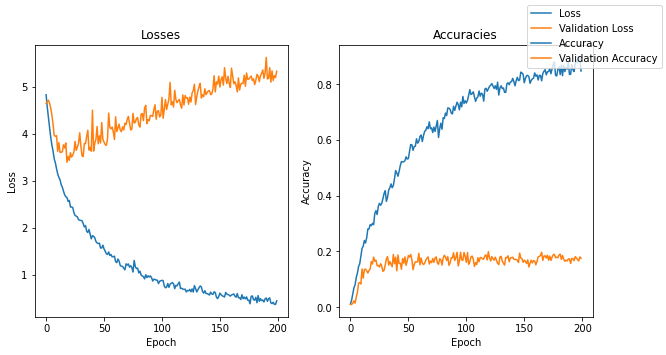

In [10]:
history = {'loss': [4.827141, 4.56281, 4.356138, 4.131297, 3.919278, 3.756835, 3.628788, 3.4635, 3.379064, 3.254295, 3.145828, 3.070816, 3.02098, 2.917529, 2.861798, 2.776776, 2.70101, 2.657694, 2.641558, 2.558731, 2.579864, 2.438574, 2.442115, 2.427737, 2.320088, 2.259438, 2.246041, 2.228629, 2.171344, 2.157561, 2.154099, 2.148007, 2.08924, 2.015587, 2.044984, 1.9243, 1.896896, 1.962463, 1.862312, 1.762352, 1.829557, 1.816532, 1.786978, 1.706634, 1.675121, 1.66083, 1.671115, 1.568088, 1.567914, 1.628695, 1.547852, 1.499316, 1.444154, 1.431993, 1.483676, 1.408237, 1.42954, 1.380216, 1.383109, 1.393606, 1.279393, 1.256235, 1.333803, 1.288978, 1.193553, 1.181277, 1.176265, 1.141236, 1.102548, 1.230497, 1.204682, 1.228797, 1.160551, 1.190373, 1.152947, 1.056317, 1.302686, 1.171458, 1.129608, 1.138365, 1.037643, 1.075257, 0.99248, 0.9726, 0.958023, 0.910719, 0.999005, 0.938343, 0.976487, 0.950545, 0.974544, 0.939103, 0.864933, 0.904337, 0.898482, 0.884624, 0.883768, 0.81046, 0.862001, 0.871731, 0.879384, 0.874914, 0.759648, 0.721353, 0.736747, 0.811988, 0.730963, 0.799119, 0.816848, 0.83271, 0.80329, 0.702886, 0.774274, 0.762328, 0.805651, 0.843741, 0.705287, 0.713131, 0.693823, 0.686181, 0.692443, 0.631839, 0.664679, 0.656722, 0.687357, 0.636233, 0.697002, 0.630737, 0.766542, 0.705967, 0.633666, 0.680271, 0.722946, 0.760091, 0.740664, 0.642004, 0.608006, 0.659875, 0.599922, 0.597275, 0.585351, 0.566937, 0.628487, 0.591476, 0.579687, 0.636583, 0.619017, 0.524177, 0.489411, 0.536238, 0.607054, 0.573296, 0.551804, 0.537709, 0.525997, 0.622514, 0.58616, 0.575323, 0.566005, 0.543914, 0.568274, 0.577935, 0.590605, 0.544068, 0.520669, 0.599059, 0.509452, 0.508078, 0.472856, 0.573561, 0.489631, 0.523756, 0.485408, 0.527649, 0.456918, 0.45914, 0.381314, 0.541132, 0.547536, 0.467997, 0.458648, 0.519298, 0.403245, 0.555972, 0.433582, 0.490901, 0.44845, 0.460738, 0.420083, 0.488785, 0.503905, 0.433348, 0.489239, 0.50719, 0.398041, 0.385036, 0.414123, 0.369619, 0.367088, 0.44424], 'accuracy': [0.011765, 0.02549, 0.048039, 0.069608, 0.080392, 0.106863, 0.122549, 0.146078, 0.155882, 0.182353, 0.210784, 0.218627, 0.239216, 0.230392, 0.24902, 0.280392, 0.280392, 0.296078, 0.292157, 0.30098, 0.296078, 0.336275, 0.346078, 0.332353, 0.360784, 0.372549, 0.365686, 0.372549, 0.389216, 0.407843, 0.417647, 0.379412, 0.394118, 0.420588, 0.428431, 0.442157, 0.428431, 0.436274, 0.460784, 0.490196, 0.481373, 0.469608, 0.487255, 0.507843, 0.522549, 0.520588, 0.521569, 0.52549, 0.539216, 0.531373, 0.533333, 0.559804, 0.583333, 0.582353, 0.562745, 0.576471, 0.577451, 0.603922, 0.588235, 0.595098, 0.612745, 0.617647, 0.594118, 0.614706, 0.630392, 0.634314, 0.647059, 0.640196, 0.664706, 0.640196, 0.643137, 0.626471, 0.646078, 0.630392, 0.65, 0.669608, 0.608824, 0.640196, 0.659804, 0.638235, 0.679412, 0.676471, 0.696078, 0.687255, 0.714706, 0.713726, 0.709804, 0.696078, 0.693137, 0.720588, 0.705882, 0.721569, 0.735294, 0.726471, 0.707843, 0.735294, 0.718627, 0.755882, 0.730392, 0.740196, 0.732353, 0.742157, 0.759804, 0.780392, 0.762745, 0.765686, 0.772549, 0.753922, 0.738235, 0.75, 0.754902, 0.77549, 0.756863, 0.767647, 0.763726, 0.739216, 0.782353, 0.785294, 0.77451, 0.783333, 0.792157, 0.796078, 0.801961, 0.793137, 0.784314, 0.794118, 0.781373, 0.806863, 0.760784, 0.786274, 0.794118, 0.784314, 0.786274, 0.770588, 0.770588, 0.80098, 0.804902, 0.798039, 0.807843, 0.808824, 0.820588, 0.809804, 0.794118, 0.811765, 0.82451, 0.812745, 0.814706, 0.843137, 0.840196, 0.835294, 0.804902, 0.820588, 0.830392, 0.831373, 0.826471, 0.802941, 0.813725, 0.818627, 0.821569, 0.840196, 0.828431, 0.833333, 0.814706, 0.831373, 0.831373, 0.811765, 0.838235, 0.846078, 0.851961, 0.833333, 0.844118, 0.845098, 0.855882, 0.837255, 0.854902, 0.869608, 0.879412, 0.831373, 0.829412, 0.853922, 0.861765, 0.834314, 0.868627, 0.830392, 0.867647, 0.845098, 0.859804, 0.853922, 0.878431, 0.835294, 0.835294, 0.869608, 0.851961, 0.845098, 0.876471, 0.883333, 0.876471, 0.896078, 0.892157, 0.847059], 'val_loss': [4.64173, 4.682305, 4.71227, 4.646257, 4.544908, 4.391193, 4.20047, 3.959508, 3.945776, 3.957477, 3.624654, 3.807947, 3.600814, 3.608642, 3.612184, 3.762551, 3.695376, 3.802253, 3.392348, 3.515712, 3.434105, 3.594613, 3.501024, 3.541099, 3.613803, 3.835828, 3.644294, 3.714646, 3.794587, 4.018315, 3.743017, 3.531252, 3.51261, 3.792866, 3.787065, 3.939685, 4.073068, 3.649978, 3.709349, 3.627394, 4.498772, 3.628612, 3.794061, 3.879219, 4.152781, 3.784541, 3.954013, 3.802514, 4.235007, 3.876244, 3.822597, 3.766673, 3.750564, 3.886775, 4.436375, 4.131654, 4.103871, 4.14077, 4.038251, 3.87549, 4.358374, 4.043965, 4.127295, 4.202302, 4.075429, 4.041008, 4.146458, 4.079492, 4.221845, 4.193811, 4.303424, 4.368077, 4.219231, 4.079128, 4.099042, 4.43167, 4.226112, 4.241165, 4.321485, 4.343378, 4.185924, 4.139509, 4.415087, 4.428259, 4.277427, 4.546555, 4.60283, 4.215548, 4.300313, 4.273489, 4.389257, 4.381527, 4.36482, 4.511266, 4.61506, 4.307689, 4.477815, 4.488895, 4.355718, 4.394697, 4.771336, 4.32734, 4.535381, 4.72458, 4.513364, 4.619261, 4.734628, 5.090412, 4.614018, 4.678804, 4.565462, 4.922328, 4.72733, 4.658251, 4.701639, 4.728079, 4.609523, 4.543146, 4.824745, 4.609752, 4.811177, 4.757236, 4.76297, 4.625244, 4.777911, 4.673152, 4.862387, 4.918112, 5.050512, 4.619946, 4.778518, 4.90854, 4.995984, 5.070333, 4.757738, 4.828002, 4.787056, 4.954843, 4.828258, 4.874029, 4.91113, 4.912934, 4.83124, 4.843857, 4.957571, 5.233062, 4.888095, 5.099985, 5.05715, 5.221432, 4.992119, 5.151477, 5.210765, 5.033463, 5.403187, 5.182581, 5.066461, 5.220603, 5.077764, 4.982269, 5.391845, 5.227829, 5.061342, 5.103676, 5.025475, 4.888852, 5.187236, 4.927723, 5.052068, 5.072529, 5.064571, 5.242447, 5.007095, 5.290495, 5.154612, 5.16145, 5.193032, 5.224468, 5.130614, 5.166015, 5.044544, 5.134326, 5.260113, 5.225777, 5.106769, 5.234573, 5.282064, 5.354243, 5.176922, 5.291261, 5.623223, 5.164971, 5.177016, 5.401754, 5.095049, 5.335778, 5.131989, 5.231545, 5.194269, 5.327464], 'val_accuracy': [0.009804, 0.009804, 0.014706, 0.022549, 0.014706, 0.036275, 0.052941, 0.086275, 0.088235, 0.083333, 0.137255, 0.103922, 0.135294, 0.136275, 0.130392, 0.122549, 0.131373, 0.137255, 0.163725, 0.154902, 0.179412, 0.164706, 0.168627, 0.14902, 0.15, 0.144118, 0.155882, 0.147059, 0.128431, 0.132353, 0.15098, 0.173529, 0.181373, 0.15098, 0.163725, 0.153922, 0.145098, 0.189216, 0.155882, 0.179412, 0.130392, 0.187255, 0.156863, 0.157843, 0.136275, 0.17451, 0.157843, 0.180392, 0.15, 0.166667, 0.185294, 0.179412, 0.189216, 0.170588, 0.134314, 0.152941, 0.162745, 0.161765, 0.162745, 0.193137, 0.151961, 0.176471, 0.157843, 0.152941, 0.156863, 0.168627, 0.17549, 0.180392, 0.154902, 0.165686, 0.159804, 0.17451, 0.160784, 0.176471, 0.180392, 0.158824, 0.153922, 0.173529, 0.170588, 0.15098, 0.176471, 0.186275, 0.179412, 0.167647, 0.181373, 0.15, 0.158824, 0.177451, 0.176471, 0.195098, 0.167647, 0.178431, 0.197059, 0.148039, 0.164706, 0.197059, 0.169608, 0.167647, 0.196078, 0.182353, 0.160784, 0.196078, 0.153922, 0.162745, 0.180392, 0.183333, 0.172549, 0.146078, 0.159804, 0.152941, 0.177451, 0.162745, 0.178431, 0.177451, 0.172549, 0.172549, 0.184314, 0.187255, 0.169608, 0.19902, 0.177451, 0.165686, 0.181373, 0.173529, 0.168627, 0.179412, 0.167647, 0.156863, 0.152941, 0.180392, 0.182353, 0.165686, 0.157843, 0.15098, 0.178431, 0.177451, 0.184314, 0.162745, 0.176471, 0.177451, 0.179412, 0.171569, 0.171569, 0.171569, 0.168627, 0.160784, 0.194118, 0.176471, 0.17451, 0.160784, 0.168627, 0.163725, 0.156863, 0.169608, 0.144118, 0.157843, 0.168627, 0.158824, 0.166667, 0.165686, 0.151961, 0.164706, 0.180392, 0.182353, 0.185294, 0.197059, 0.167647, 0.183333, 0.184314, 0.176471, 0.186275, 0.168627, 0.183333, 0.167647, 0.179412, 0.188235, 0.189216, 0.177451, 0.179412, 0.177451, 0.187255, 0.190196, 0.171569, 0.185294, 0.172549, 0.164706, 0.168627, 0.165686, 0.172549, 0.173529, 0.156863, 0.17451, 0.17451, 0.166667, 0.181373, 0.176471, 0.170588, 0.165686, 0.180392, 0.17549]}

run_summary(history)

## Model 23
* Conv Regularization
* depth=4, skips=[3], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.42451 | 0.130392


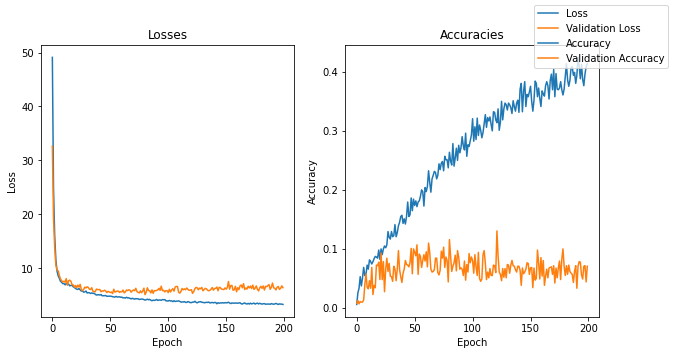

In [11]:
history = {'loss': [49.104721, 24.87986, 16.134159, 11.68598, 9.52824, 8.634175, 8.190426, 7.614496, 7.42422, 7.173654, 7.187287, 6.949512, 7.205857, 7.012407, 7.082625, 6.765669, 6.841861, 6.864913, 6.598016, 6.443743, 6.288712, 6.142435, 6.091511, 6.276022, 6.016098, 5.794619, 5.804699, 5.592471, 5.629683, 5.803282, 5.440473, 5.507003, 5.47493, 5.346219, 5.44811, 5.358766, 5.401378, 5.208525, 5.060342, 5.099902, 5.117173, 5.052561, 5.150834, 4.927332, 4.92526, 4.937878, 4.971519, 4.830443, 4.835747, 4.829517, 4.854571, 4.821264, 4.750608, 4.70595, 4.679461, 4.809733, 4.683468, 4.716214, 4.724179, 4.649232, 4.667129, 4.53315, 4.555341, 4.509916, 4.644814, 4.521854, 4.537756, 4.436037, 4.344967, 4.461193, 4.364965, 4.298751, 4.391771, 4.361638, 4.36834, 4.23615, 4.266584, 4.31463, 4.303538, 4.206004, 4.124215, 4.192389, 4.296259, 4.176543, 4.257983, 4.103611, 4.00464, 4.110946, 4.056879, 4.126235, 4.239719, 4.057762, 4.141536, 4.133103, 4.085115, 4.214715, 4.190412, 4.213572, 4.005154, 3.954551, 3.960246, 4.052332, 3.949003, 3.980746, 3.843508, 3.999296, 3.859065, 3.928994, 3.921986, 3.973121, 3.888718, 3.740782, 3.792915, 3.768756, 3.846401, 3.696232, 3.70242, 3.843573, 3.76943, 3.655286, 3.656454, 3.745739, 3.731827, 3.906515, 3.709942, 3.608725, 3.756242, 3.78921, 3.828837, 3.710782, 3.699781, 3.63533, 3.657576, 3.715962, 3.689611, 3.752455, 3.588326, 3.650049, 3.685345, 3.609477, 3.675416, 3.677194, 3.443113, 3.636504, 3.54423, 3.60205, 3.59527, 3.628364, 3.587258, 3.632529, 3.623526, 3.627384, 3.731908, 3.586498, 3.476549, 3.587832, 3.57045, 3.546904, 3.58894, 3.574628, 3.546902, 3.592957, 3.617288, 3.437764, 3.403316, 3.51432, 3.603571, 3.455593, 3.394305, 3.515828, 3.392769, 3.550659, 3.411847, 3.484361, 3.565182, 3.387393, 3.494948, 3.555285, 3.409401, 3.531137, 3.438098, 3.379324, 3.451039, 3.46839, 3.352267, 3.390315, 3.395953, 3.386534, 3.355715, 3.462447, 3.399327, 3.361608, 3.414135, 3.504418, 3.402439, 3.315898, 3.41845, 3.381543, 3.374772, 3.319225], 'accuracy': [0.005882, 0.02549, 0.033333, 0.052941, 0.037255, 0.05098, 0.068627, 0.054902, 0.056863, 0.072549, 0.065686, 0.081373, 0.078431, 0.07451, 0.078431, 0.083333, 0.087255, 0.086275, 0.084314, 0.098039, 0.082353, 0.1, 0.090196, 0.1, 0.104902, 0.101961, 0.106863, 0.129412, 0.119608, 0.116667, 0.129412, 0.120588, 0.122549, 0.141176, 0.120588, 0.127451, 0.139216, 0.145098, 0.154902, 0.156863, 0.143137, 0.15098, 0.142157, 0.154902, 0.179412, 0.154902, 0.157843, 0.186275, 0.164706, 0.184314, 0.173529, 0.181373, 0.171569, 0.179412, 0.181373, 0.189216, 0.2, 0.197059, 0.172549, 0.203922, 0.197059, 0.205882, 0.232353, 0.212745, 0.196078, 0.218627, 0.22451, 0.231373, 0.229412, 0.218627, 0.22451, 0.244118, 0.234314, 0.245098, 0.248039, 0.232353, 0.256863, 0.25098, 0.25098, 0.237255, 0.263725, 0.24902, 0.242157, 0.278431, 0.240196, 0.253922, 0.270588, 0.25, 0.27549, 0.262745, 0.271569, 0.290196, 0.27451, 0.267647, 0.296078, 0.256863, 0.276471, 0.273529, 0.283333, 0.293137, 0.320588, 0.282353, 0.306863, 0.285294, 0.321569, 0.292157, 0.309804, 0.30098, 0.288235, 0.297059, 0.311765, 0.327451, 0.305882, 0.322549, 0.316667, 0.323529, 0.310784, 0.3, 0.332353, 0.331373, 0.318627, 0.313726, 0.337255, 0.30098, 0.314706, 0.35, 0.318627, 0.337255, 0.347059, 0.344118, 0.335294, 0.347059, 0.344118, 0.339216, 0.329412, 0.35098, 0.341176, 0.333333, 0.347059, 0.351961, 0.331373, 0.370588, 0.380392, 0.332353, 0.366667, 0.383333, 0.341176, 0.361765, 0.357843, 0.365686, 0.37549, 0.35, 0.333333, 0.351961, 0.384314, 0.380392, 0.357843, 0.372549, 0.354902, 0.341176, 0.367647, 0.362745, 0.358824, 0.376471, 0.383333, 0.376471, 0.353922, 0.385294, 0.396078, 0.369608, 0.403922, 0.357843, 0.397059, 0.370588, 0.369608, 0.372549, 0.383333, 0.369608, 0.360784, 0.370588, 0.391176, 0.413725, 0.386275, 0.37549, 0.385294, 0.406863, 0.408824, 0.394118, 0.39902, 0.380392, 0.394118, 0.42451, 0.409804, 0.388235, 0.412745, 0.387255, 0.376471, 0.396078, 0.408824, 0.413725], 'val_loss': [32.665932, 19.35136, 13.964818, 10.655586, 9.727202, 9.55403, 8.696532, 8.027911, 7.734971, 7.459528, 7.630546, 7.430208, 8.1049, 6.864527, 7.715331, 7.808461, 7.622952, 6.977237, 6.951519, 6.497219, 6.841789, 6.409949, 6.900113, 6.534784, 7.034739, 6.093421, 5.859841, 6.081083, 6.525479, 6.367721, 6.5788, 6.476131, 6.138323, 6.094794, 6.413908, 5.755488, 5.698978, 5.673295, 6.157905, 6.082428, 6.064831, 6.073716, 5.67751, 5.835475, 5.772267, 5.949834, 5.829132, 5.520059, 5.749971, 5.656363, 5.518761, 5.616603, 5.337178, 6.131441, 5.606831, 5.678492, 5.80751, 5.797906, 5.536609, 5.714232, 5.650224, 5.977611, 5.452583, 5.639476, 5.991513, 5.87743, 6.037773, 5.959062, 5.58538, 5.835503, 6.00492, 5.85192, 6.306894, 5.71341, 5.544231, 5.457847, 5.83424, 5.487257, 5.786074, 6.330785, 5.130835, 5.576611, 6.401571, 5.884802, 5.833139, 5.457685, 6.013533, 5.378351, 5.880517, 5.852937, 5.906529, 6.022035, 6.309832, 5.934261, 6.708418, 5.869199, 5.940638, 5.640252, 5.872121, 5.87535, 5.506091, 6.120143, 5.63185, 6.009758, 6.243645, 5.777822, 6.544693, 6.655814, 6.630145, 5.583594, 5.408467, 5.73478, 6.273993, 6.03323, 6.203751, 6.047118, 6.360609, 6.112252, 5.923438, 5.954671, 6.048318, 5.368801, 5.684028, 6.241929, 6.467459, 6.401034, 6.028512, 6.348213, 6.209113, 6.47474, 5.836051, 6.088354, 6.299391, 6.20841, 5.94875, 5.840165, 5.941114, 6.148871, 6.457257, 5.955976, 6.261604, 6.298516, 6.543578, 5.851031, 6.498634, 6.417941, 6.152728, 6.13075, 6.069119, 6.381814, 6.146712, 6.446472, 7.573134, 6.146803, 6.808526, 6.835911, 5.939869, 6.046523, 6.675604, 5.668772, 6.417437, 6.061715, 6.753336, 6.925703, 6.393769, 7.164604, 6.079455, 6.366051, 6.162239, 6.687585, 6.370407, 6.727137, 6.260744, 6.891437, 6.104677, 6.330717, 6.748652, 6.100469, 5.815093, 6.413166, 6.684122, 6.29631, 6.733003, 5.993341, 6.672043, 6.593854, 6.825, 6.996601, 6.124276, 6.513781, 7.28522, 6.386689, 6.319718, 6.000551, 6.522107, 6.640911, 6.103399, 6.299666, 6.755222, 6.415939], 'val_accuracy': [0.007843, 0.012745, 0.006863, 0.010784, 0.009804, 0.009804, 0.013725, 0.039216, 0.057843, 0.035294, 0.032353, 0.046078, 0.033333, 0.068627, 0.022549, 0.038235, 0.034314, 0.072549, 0.071569, 0.077451, 0.048039, 0.093137, 0.048039, 0.078431, 0.027451, 0.064706, 0.084314, 0.061765, 0.07549, 0.053922, 0.052941, 0.045098, 0.070588, 0.065686, 0.046078, 0.065686, 0.097059, 0.064706, 0.052941, 0.043137, 0.058824, 0.065686, 0.080392, 0.073529, 0.072549, 0.069608, 0.076471, 0.10098, 0.057843, 0.1, 0.094118, 0.088235, 0.106863, 0.056863, 0.091176, 0.087255, 0.068627, 0.080392, 0.090196, 0.079412, 0.095098, 0.069608, 0.109804, 0.094118, 0.065686, 0.060784, 0.061765, 0.064706, 0.084314, 0.084314, 0.059804, 0.055882, 0.063725, 0.096078, 0.084314, 0.102941, 0.068627, 0.086275, 0.080392, 0.044118, 0.115686, 0.089216, 0.061765, 0.070588, 0.076471, 0.089216, 0.062745, 0.097059, 0.086275, 0.065686, 0.067647, 0.065686, 0.054902, 0.079412, 0.047059, 0.073529, 0.060784, 0.092157, 0.076471, 0.086275, 0.080392, 0.058824, 0.090196, 0.069608, 0.054902, 0.094118, 0.05, 0.045098, 0.04902, 0.090196, 0.097059, 0.07549, 0.048039, 0.060784, 0.05098, 0.066667, 0.054902, 0.054902, 0.072549, 0.071569, 0.059804, 0.130392, 0.088235, 0.060784, 0.056863, 0.046078, 0.066667, 0.051961, 0.066667, 0.05098, 0.073529, 0.072549, 0.058824, 0.072549, 0.080392, 0.071569, 0.070588, 0.064706, 0.060784, 0.070588, 0.070588, 0.063725, 0.038235, 0.067647, 0.057843, 0.060784, 0.065686, 0.076471, 0.07549, 0.056863, 0.067647, 0.068627, 0.034314, 0.067647, 0.047059, 0.05, 0.098039, 0.076471, 0.04902, 0.085294, 0.053922, 0.080392, 0.038235, 0.053922, 0.065686, 0.05098, 0.067647, 0.068627, 0.069608, 0.056863, 0.071569, 0.042157, 0.067647, 0.05098, 0.067647, 0.079412, 0.048039, 0.082353, 0.1, 0.070588, 0.054902, 0.071569, 0.056863, 0.072549, 0.061765, 0.058824, 0.056863, 0.043137, 0.061765, 0.071569, 0.033333, 0.070588, 0.078431, 0.077451, 0.055882, 0.04902, 0.070588, 0.071569, 0.044118, 0.070588]}

run_summary(history)

## Model 24
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.890196 | 0.469608


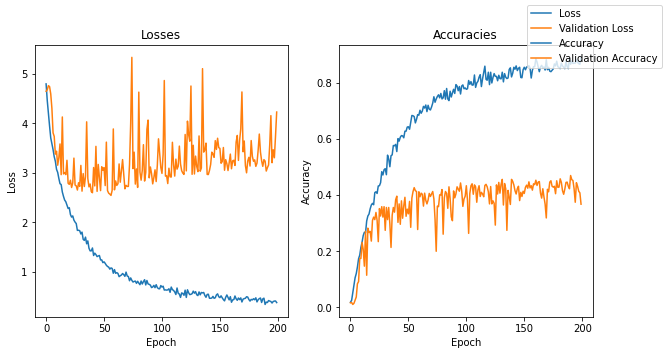

In [12]:
history = {'loss': [4.798003, 4.460454, 4.196811, 3.945573, 3.706277, 3.58622, 3.471221, 3.326154, 3.232068, 3.070699, 3.009557, 2.887471, 2.780599, 2.764032, 2.612877, 2.52535, 2.450009, 2.41576, 2.34875, 2.280113, 2.295266, 2.157853, 2.105288, 2.129671, 2.044297, 2.004486, 1.974922, 1.836739, 1.840532, 1.830055, 1.764795, 1.801557, 1.656554, 1.634751, 1.700681, 1.566015, 1.624551, 1.476205, 1.423194, 1.423612, 1.481281, 1.329355, 1.37716, 1.348026, 1.307208, 1.319778, 1.329611, 1.239934, 1.240911, 1.18507, 1.201204, 1.170504, 1.132498, 1.108055, 1.094522, 1.053856, 1.078316, 1.067984, 0.970689, 1.044104, 0.969857, 0.983152, 0.966943, 0.902001, 0.920214, 0.935203, 0.965102, 0.942632, 0.908075, 0.993558, 0.91496, 0.904376, 0.819077, 0.875894, 0.827096, 0.793184, 0.805503, 0.811898, 0.766228, 0.808706, 0.771282, 0.739374, 0.813851, 0.753126, 0.801844, 0.840088, 0.734145, 0.824123, 0.754789, 0.746007, 0.730707, 0.681228, 0.692047, 0.725935, 0.678995, 0.739108, 0.681037, 0.659175, 0.656513, 0.721888, 0.691468, 0.70918, 0.630924, 0.63457, 0.629438, 0.634287, 0.656647, 0.585271, 0.69116, 0.640371, 0.623361, 0.593614, 0.541043, 0.672313, 0.566885, 0.549105, 0.482322, 0.573475, 0.56085, 0.525098, 0.629236, 0.482005, 0.636397, 0.577014, 0.538439, 0.545491, 0.557573, 0.608649, 0.567576, 0.599221, 0.535618, 0.51917, 0.593255, 0.534828, 0.581596, 0.573663, 0.581919, 0.522006, 0.485251, 0.542794, 0.546457, 0.465163, 0.464949, 0.469284, 0.503092, 0.463676, 0.475125, 0.532899, 0.553783, 0.49619, 0.477996, 0.514292, 0.473727, 0.438183, 0.412101, 0.48442, 0.531552, 0.480628, 0.432538, 0.497453, 0.384791, 0.432286, 0.437646, 0.510871, 0.454055, 0.423615, 0.470688, 0.437483, 0.471968, 0.39014, 0.447125, 0.458685, 0.464535, 0.495893, 0.489563, 0.440073, 0.40805, 0.441821, 0.43192, 0.455363, 0.434955, 0.473933, 0.391666, 0.435597, 0.457795, 0.469886, 0.379803, 0.451457, 0.466888, 0.340052, 0.387451, 0.379347, 0.418377, 0.408725, 0.399026, 0.368707, 0.399756, 0.408421, 0.410428, 0.377803], 'accuracy': [0.018627, 0.02549, 0.052941, 0.080392, 0.105882, 0.120588, 0.144118, 0.173529, 0.186275, 0.213725, 0.232353, 0.255882, 0.267647, 0.265686, 0.307843, 0.32549, 0.332353, 0.35098, 0.364706, 0.370588, 0.365686, 0.408824, 0.411765, 0.405882, 0.432353, 0.433333, 0.444118, 0.483333, 0.471569, 0.490196, 0.494118, 0.472549, 0.542157, 0.528431, 0.50098, 0.540196, 0.543137, 0.576471, 0.57549, 0.580392, 0.554902, 0.60098, 0.592157, 0.605882, 0.611765, 0.610784, 0.603922, 0.627451, 0.627451, 0.642157, 0.643137, 0.634314, 0.659804, 0.683333, 0.682353, 0.679412, 0.656863, 0.669608, 0.686275, 0.684314, 0.701961, 0.691176, 0.69902, 0.715686, 0.709804, 0.720588, 0.697059, 0.719608, 0.705882, 0.702941, 0.713726, 0.727451, 0.75, 0.730392, 0.742157, 0.75098, 0.756863, 0.746078, 0.761765, 0.742157, 0.746078, 0.771569, 0.741176, 0.779412, 0.742157, 0.736274, 0.769608, 0.74902, 0.763726, 0.776471, 0.761765, 0.793137, 0.788235, 0.771569, 0.786274, 0.759804, 0.788235, 0.792157, 0.778431, 0.781373, 0.776471, 0.778431, 0.807843, 0.794118, 0.803922, 0.791176, 0.792157, 0.827451, 0.783333, 0.79902, 0.804902, 0.819608, 0.828431, 0.786274, 0.813725, 0.835294, 0.858824, 0.811765, 0.808824, 0.837255, 0.793137, 0.837255, 0.79902, 0.818627, 0.832353, 0.822549, 0.822549, 0.806863, 0.826471, 0.814706, 0.813725, 0.837255, 0.802941, 0.832353, 0.819608, 0.814706, 0.816667, 0.847059, 0.852941, 0.820588, 0.833333, 0.854902, 0.848039, 0.859804, 0.843137, 0.85098, 0.854902, 0.818627, 0.817647, 0.846078, 0.854902, 0.846078, 0.855882, 0.856863, 0.860784, 0.851961, 0.816667, 0.844118, 0.856863, 0.856863, 0.885294, 0.873529, 0.855882, 0.839216, 0.855882, 0.861765, 0.851961, 0.855882, 0.845098, 0.881373, 0.846078, 0.854902, 0.841176, 0.839216, 0.844118, 0.84902, 0.866667, 0.859804, 0.876471, 0.856863, 0.853922, 0.85, 0.869608, 0.859804, 0.854902, 0.85, 0.876471, 0.856863, 0.85, 0.888235, 0.865686, 0.877451, 0.868627, 0.869608, 0.869608, 0.882353, 0.872549, 0.867647, 0.865686, 0.890196], 'val_loss': [4.649771, 4.678938, 4.763077, 4.742518, 4.595638, 4.305463, 3.80994, 3.736205, 3.378464, 3.437658, 3.154369, 3.307925, 3.584253, 2.963182, 4.129535, 2.97924, 3.006475, 2.964588, 3.254217, 2.78963, 2.76731, 2.851557, 2.704131, 2.79633, 3.297772, 2.752903, 2.737159, 2.652859, 2.799893, 2.726282, 3.150414, 2.630061, 2.984739, 2.724096, 2.925935, 4.031263, 2.886441, 2.716718, 2.774466, 2.620624, 2.598662, 3.107241, 2.735675, 3.535487, 2.625667, 3.170058, 2.901403, 2.640965, 3.123266, 3.053741, 3.105561, 2.742682, 3.620998, 2.641536, 2.589227, 2.570251, 2.544298, 2.645968, 3.88746, 2.656819, 2.836305, 2.746152, 2.780672, 3.180283, 2.811076, 3.031935, 3.268155, 2.959562, 2.677274, 2.747315, 2.725648, 2.72588, 3.169628, 3.999005, 5.334603, 3.085073, 3.418075, 2.772766, 3.078676, 2.705419, 4.631684, 3.014209, 2.851891, 3.050056, 3.569112, 2.834211, 3.008425, 3.877594, 4.067196, 2.899244, 3.118257, 2.983776, 2.777373, 2.905011, 3.060903, 2.824081, 3.1583, 3.687791, 3.39822, 3.107788, 2.989115, 3.379354, 4.866427, 2.93311, 2.944577, 2.783746, 3.093472, 2.919469, 2.91557, 3.617735, 3.167565, 2.934627, 3.277569, 3.075194, 3.133987, 3.540726, 3.180494, 3.044256, 2.995954, 2.968816, 3.775508, 3.039641, 4.045116, 3.77302, 3.640196, 4.75534, 2.970408, 3.557664, 2.977491, 3.338502, 3.129936, 3.02476, 3.746226, 3.033842, 3.098113, 5.106266, 3.419275, 3.464476, 3.601229, 2.968786, 2.966269, 3.049292, 3.168603, 3.418052, 3.380034, 3.313774, 3.651168, 3.474137, 3.699568, 3.509345, 3.495385, 3.194178, 3.227595, 3.51228, 3.052435, 3.26667, 3.187135, 3.047042, 3.202637, 3.379262, 3.082795, 3.243556, 3.254067, 3.149562, 3.621602, 3.756087, 3.251922, 3.655721, 3.888108, 4.63522, 3.426396, 3.643823, 3.148881, 3.000796, 3.237719, 3.313886, 3.137611, 3.652841, 3.333904, 3.234229, 3.262357, 3.130916, 3.197127, 3.455552, 3.784107, 3.420388, 3.244947, 3.131594, 3.267102, 3.237652, 3.036752, 3.105413, 3.158258, 3.56462, 4.156411, 3.204682, 3.46711, 3.304832, 3.744192, 4.229105], 'val_accuracy': [0.016667, 0.017647, 0.010784, 0.014706, 0.02549, 0.037255, 0.084314, 0.092157, 0.17451, 0.17451, 0.231373, 0.206863, 0.147059, 0.271569, 0.114706, 0.282353, 0.266667, 0.270588, 0.236275, 0.309804, 0.321569, 0.312745, 0.338235, 0.309804, 0.234314, 0.351961, 0.32549, 0.358824, 0.321569, 0.358824, 0.27451, 0.355882, 0.312745, 0.355882, 0.297059, 0.213725, 0.328431, 0.355882, 0.339216, 0.383333, 0.396078, 0.302941, 0.368627, 0.296078, 0.379412, 0.317647, 0.361765, 0.392157, 0.32451, 0.35, 0.333333, 0.377451, 0.285294, 0.389216, 0.412745, 0.426471, 0.415686, 0.412745, 0.277451, 0.411765, 0.394118, 0.406863, 0.402941, 0.360784, 0.406863, 0.381373, 0.368627, 0.382353, 0.405882, 0.395098, 0.403922, 0.412745, 0.386275, 0.313726, 0.2, 0.360784, 0.358824, 0.40098, 0.4, 0.419608, 0.260784, 0.390196, 0.412745, 0.405882, 0.352941, 0.429412, 0.387255, 0.322549, 0.308824, 0.414706, 0.390196, 0.403922, 0.429412, 0.421569, 0.413725, 0.443137, 0.414706, 0.359804, 0.386275, 0.396078, 0.433333, 0.381373, 0.263725, 0.405882, 0.433333, 0.440196, 0.402941, 0.436274, 0.429412, 0.37451, 0.418627, 0.433333, 0.395098, 0.409804, 0.403922, 0.394118, 0.434314, 0.438235, 0.429412, 0.411765, 0.368627, 0.430392, 0.368627, 0.379412, 0.370588, 0.293137, 0.436274, 0.403922, 0.445098, 0.406863, 0.438235, 0.455882, 0.364706, 0.441176, 0.422549, 0.27451, 0.416667, 0.393137, 0.366667, 0.455882, 0.44902, 0.436274, 0.415686, 0.403922, 0.422549, 0.431373, 0.380392, 0.409804, 0.395098, 0.413725, 0.405882, 0.427451, 0.435294, 0.42451, 0.447059, 0.42549, 0.433333, 0.417647, 0.440196, 0.437255, 0.452941, 0.434314, 0.446078, 0.448039, 0.406863, 0.389216, 0.422549, 0.393137, 0.367647, 0.318627, 0.420588, 0.411765, 0.446078, 0.45098, 0.431373, 0.428431, 0.431373, 0.404902, 0.45098, 0.427451, 0.428431, 0.457843, 0.445098, 0.415686, 0.402941, 0.421569, 0.445098, 0.446078, 0.431373, 0.422549, 0.469608, 0.454902, 0.451961, 0.422549, 0.37451, 0.444118, 0.431373, 0.413725, 0.407843, 0.367647]}

run_summary(history)